In [1]:
library(tidyverse)
library(DESeq2)  # mamba install bioconductor-deseq2
library(factoextra)
library(RColorBrewer)
library(gplots)
library(pheatmap)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
Warning message:
“package ‘tidyr’ was built under R version 4.3.2”
Warning message:
“package ‘readr’ was built under R version 4.3.2”
Warning message:
“package ‘purrr’ was built under R version 4.3.1”
Warning message:
“package ‘dplyr’ was built under R version 4.3.2”
Warning message:
“package ‘stringr’ was built under R version 4.3.2”
Warning message:
“package ‘lubridate’ was built under R version 4.3.1”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

# DESeq2 DE Analysis Pipeline

> https://zhuanlan.zhihu.com/p/375756362

- 依赖包:
   - DESeq2
   - RColorBrewer
   - gplots
   - pheatmap
   - ggplot2
- DESeq2对于输入数据的要求
   - 输入数据为整数构成的矩阵
   - 此矩阵必须是没有经过标准化(归一化/Normalize) 
- DESeq2进行差异表达分析
   - 构建dds矩阵
       ```
       dds <- DESeqDataSetFromMatrix(
                   countData = raw_counts, 
                   colData = column_info, 
                   design= ~ batch + condition) 
       #~在R里面用于构建公式对象，~左边为因变量，右边为自变量。
       ```

   - 标准化/归一化
       ```
       dds <- DESeq(dds) 
       #标准化
       ```
   - 差异分析
       ```
       res <- results(dds, contrast=c("condition","treated","control")) 
       #差异分析结果
       ```

## load tables

1. 读取样本信息（sample.txt）
2. 读取featureCounts产生的各个bam文件的counts信息
3. 检查raw_counts中的所有记录(row)的个数，这里代表count到的gene的个数, geneid被指定为row.names了所以不计在内

### 读取/构建样本信息

In [2]:
column_info <- read.table("../featureCounts/sample.csv", header=TRUE, sep=',')
column_info

sample,condition,type
<chr>,<chr>,<chr>
CTCF_AID_untreated_rep1,CTCF_AID_untreated,untreated
CTCF_AID_untreated_rep2,CTCF_AID_untreated,untreated
CTCF_AID_untreated_rep3,CTCF_AID_untreated,untreated
CTCF_AID_auxin1day_rep1,CTCF_AID_auxin1day,treat
CTCF_AID_auxin1day_rep2,CTCF_AID_auxin1day,treat
CTCF_AID_auxin1day_rep3,CTCF_AID_auxin1day,treat
CTCF_AID_auxin2days_rep1,CTCF_AID_auxin2days,treat
CTCF_AID_auxin2days_rep2,CTCF_AID_auxin2days,treat
CTCF_AID_auxin2days_rep3,CTCF_AID_auxin2days,treat


In [3]:
column_info$condition = factor(column_info$condition)
column_info$type = factor(column_info$type)
column_info

sample,condition,type
<chr>,<fct>,<fct>
CTCF_AID_untreated_rep1,CTCF_AID_untreated,untreated
CTCF_AID_untreated_rep2,CTCF_AID_untreated,untreated
CTCF_AID_untreated_rep3,CTCF_AID_untreated,untreated
CTCF_AID_auxin1day_rep1,CTCF_AID_auxin1day,treat
CTCF_AID_auxin1day_rep2,CTCF_AID_auxin1day,treat
CTCF_AID_auxin1day_rep3,CTCF_AID_auxin1day,treat
CTCF_AID_auxin2days_rep1,CTCF_AID_auxin2days,treat
CTCF_AID_auxin2days_rep2,CTCF_AID_auxin2days,treat
CTCF_AID_auxin2days_rep3,CTCF_AID_auxin2days,treat


### 读取原始表达矩阵

In [4]:
raw_counts <- read.table(
    "../featureCounts/all_feature_fix_feed_to_deseq2.csv",
    header=TRUE,
    sep=',',
    row.names=1
)
# raw_counts <- raw_counts[,c(1,2,3,7,8,9)]
head(raw_counts, 5)

,CTCF_AID_auxin1day_rep1,CTCF_AID_auxin1day_rep2,CTCF_AID_auxin1day_rep3,CTCF_AID_auxin2days_rep1,CTCF_AID_auxin2days_rep2,CTCF_AID_auxin2days_rep3,CTCF_AID_auxin4days_rep1,CTCF_AID_auxin4days_rep2,CTCF_AID_auxin4days_rep3,CTCF_AID_untreated_rep1,⋯,CTCF_AID_washoff2days_rep3,WT_untagged_auxin2days_rep1,WT_untagged_auxin2days_rep2,WT_untagged_auxin2days_rep3,WT_untagged_auxin4days_rep1,WT_untagged_auxin4days_rep2,WT_untagged_auxin4days_rep3,WT_untagged_untreated_rep1,WT_untagged_untreated_rep2,WT_untagged_untreated_rep3
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000102693.1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,3,0,0,1,0
ENSMUSG00000064842.1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000051951.5,2,14,49,48,21,44,22,40,91,7,⋯,34,31,2,33,65,8,20,54,28,64
ENSMUSG00000102851.1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000103377.1,0,0,0,0,2,2,0,2,0,0,⋯,0,0,0,0,0,3,0,0,3,0


In [5]:
dim(raw_counts)

[1] 55401    24

In [6]:
# 看一下column_info 中的样本名称、处理条件
column_info

sample,condition,type
<chr>,<fct>,<fct>
CTCF_AID_untreated_rep1,CTCF_AID_untreated,untreated
CTCF_AID_untreated_rep2,CTCF_AID_untreated,untreated
CTCF_AID_untreated_rep3,CTCF_AID_untreated,untreated
CTCF_AID_auxin1day_rep1,CTCF_AID_auxin1day,treat
CTCF_AID_auxin1day_rep2,CTCF_AID_auxin1day,treat
CTCF_AID_auxin1day_rep3,CTCF_AID_auxin1day,treat
CTCF_AID_auxin2days_rep1,CTCF_AID_auxin2days,treat
CTCF_AID_auxin2days_rep2,CTCF_AID_auxin2days,treat
CTCF_AID_auxin2days_rep3,CTCF_AID_auxin2days,treat


In [7]:
# 看一下raw_counts
# geneid为index，样本信息的counts数为columns
head(raw_counts)

,CTCF_AID_auxin1day_rep1,CTCF_AID_auxin1day_rep2,CTCF_AID_auxin1day_rep3,CTCF_AID_auxin2days_rep1,CTCF_AID_auxin2days_rep2,CTCF_AID_auxin2days_rep3,CTCF_AID_auxin4days_rep1,CTCF_AID_auxin4days_rep2,CTCF_AID_auxin4days_rep3,CTCF_AID_untreated_rep1,⋯,CTCF_AID_washoff2days_rep3,WT_untagged_auxin2days_rep1,WT_untagged_auxin2days_rep2,WT_untagged_auxin2days_rep3,WT_untagged_auxin4days_rep1,WT_untagged_auxin4days_rep2,WT_untagged_auxin4days_rep3,WT_untagged_untreated_rep1,WT_untagged_untreated_rep2,WT_untagged_untreated_rep3
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000102693.1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,3,0,0,1,0
ENSMUSG00000064842.1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000051951.5,2,14,49,48,21,44,22,40,91,7,⋯,34,31,2,33,65,8,20,54,28,64
ENSMUSG00000102851.1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000103377.1,0,0,0,0,2,2,0,2,0,0,⋯,0,0,0,0,0,3,0,0,3,0
ENSMUSG00000104017.1,0,0,4,0,0,8,0,12,22,0,⋯,2,0,6,2,6,24,0,2,17,2


4. 过滤掉行的和为0，也就是没有bam文件中count到reads的genes

In [8]:
### filt genes that don't express in all sample -------------------------------------------->
# 在step3是否进行了过滤？（RPKM >= 1）
raw_counts <- raw_counts[rowSums(raw_counts)>1,]
dim(raw_counts)

[1] 43304    24

### 过滤原始表达矩阵 

5. rownames函数调用矩阵的row.names
6. 调用stringr package中的str_split函数，去除geneid中的gene名的.以及后面的内容
7. 使用duplicated函数去掉重复的gn id   

In [9]:
### remove version in ensembl id ----------------------------------------------------------->
gn <- stringr::str_split(rownames(raw_counts),"\\.",simplify = T)[,1]
# gene_id如果已经是name，name这个也做不做无所谓↑
# remove duplicate
raw_counts <- raw_counts[!duplicated(gn),]
rownames(raw_counts) <- gn[!duplicated(gn)]
dim(raw_counts)

[1] 43304    24

In [10]:
head(raw_counts)

,CTCF_AID_auxin1day_rep1,CTCF_AID_auxin1day_rep2,CTCF_AID_auxin1day_rep3,CTCF_AID_auxin2days_rep1,CTCF_AID_auxin2days_rep2,CTCF_AID_auxin2days_rep3,CTCF_AID_auxin4days_rep1,CTCF_AID_auxin4days_rep2,CTCF_AID_auxin4days_rep3,CTCF_AID_untreated_rep1,⋯,CTCF_AID_washoff2days_rep3,WT_untagged_auxin2days_rep1,WT_untagged_auxin2days_rep2,WT_untagged_auxin2days_rep3,WT_untagged_auxin4days_rep1,WT_untagged_auxin4days_rep2,WT_untagged_auxin4days_rep3,WT_untagged_untreated_rep1,WT_untagged_untreated_rep2,WT_untagged_untreated_rep3
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000102693,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,3,0,0,1,0
ENSMUSG00000051951,2,14,49,48,21,44,22,40,91,7,⋯,34,31,2,33,65,8,20,54,28,64
ENSMUSG00000103377,0,0,0,0,2,2,0,2,0,0,⋯,0,0,0,0,0,3,0,0,3,0
ENSMUSG00000104017,0,0,4,0,0,8,0,12,22,0,⋯,2,0,6,2,6,24,0,2,17,2
ENSMUSG00000103025,0,0,4,0,2,0,0,6,2,0,⋯,1,1,0,0,0,3,0,0,1,0
ENSMUSG00000103201,0,0,0,0,0,0,0,2,2,0,⋯,0,0,0,0,0,0,0,0,0,0


## 构建dds矩阵

将count的矩阵输入DESeq2的DESeqDataSetFromMatrix函数中，产生dds(DEseq Data Set)


构建dds矩阵需要：

- 表达矩阵
   - 即上述代码中的countData，就是我们前面通过read count计算后并融合生成的矩阵，行row为各个基因，列col为各个样品，中间为计算reads或者fragment得到的整数。我们后面要用的是这个文件（mouse_all_count.txt）
- 样品信息
   - 矩阵即上述代码中的colData，它的类型是一个dataframe（数据框），这个东西叫【元数据】
   - 第一列是样品名称，
   - 第二列是样品的处理情况（对照还是处理等），即condition，condition的类型是一个factor
   - 第三列type可以理解为宏观的处理条件，需要时使用，用不着也可以留空
   
   - 这里我用第三列的type作为自变量(你也可以用第二列的condition)
- 差异比较矩阵
   - 即上述代码中的design。
   - 差异比较矩阵就是告诉差异分析函数是要分析哪些变量间的差异
   - 简单说就是说明哪些是对照哪些是处理。

### 指定比较对象

In [11]:
# column_info
# raw_counts

In [12]:
column_info

sample,condition,type
<chr>,<fct>,<fct>
CTCF_AID_untreated_rep1,CTCF_AID_untreated,untreated
CTCF_AID_untreated_rep2,CTCF_AID_untreated,untreated
CTCF_AID_untreated_rep3,CTCF_AID_untreated,untreated
CTCF_AID_auxin1day_rep1,CTCF_AID_auxin1day,treat
CTCF_AID_auxin1day_rep2,CTCF_AID_auxin1day,treat
CTCF_AID_auxin1day_rep3,CTCF_AID_auxin1day,treat
CTCF_AID_auxin2days_rep1,CTCF_AID_auxin2days,treat
CTCF_AID_auxin2days_rep2,CTCF_AID_auxin2days,treat
CTCF_AID_auxin2days_rep3,CTCF_AID_auxin2days,treat


In [13]:
# 指定比较对象
vcmp = c(
    'CTCF_AID_auxin4days',
    'CTCF_AID_untreated'  # untreat
)

In [14]:
column_info_filter = column_info %>% filter(condition %in% vcmp)
column_info_filter

sample,condition,type
<chr>,<fct>,<fct>
CTCF_AID_untreated_rep1,CTCF_AID_untreated,untreated
CTCF_AID_untreated_rep2,CTCF_AID_untreated,untreated
CTCF_AID_untreated_rep3,CTCF_AID_untreated,untreated
CTCF_AID_auxin4days_rep1,CTCF_AID_auxin4days,treat
CTCF_AID_auxin4days_rep2,CTCF_AID_auxin4days,treat
CTCF_AID_auxin4days_rep3,CTCF_AID_auxin4days,treat


In [15]:
raw_counts_select =  raw_counts %>% select(column_info_filter$sample)
# raw_counts_select =  raw_counts %>% select(
#     CTCF_AID_untreated_rep1, CTCF_AID_untreated_rep2, CTCF_AID_untreated_rep3,
#     CTCF_AID_auxin2days_rep1, CTCF_AID_auxin2days_rep2, CTCF_AID_auxin2days_rep3
# )
# raw_counts_select =  raw_counts
head(raw_counts_select)

,CTCF_AID_untreated_rep1,CTCF_AID_untreated_rep2,CTCF_AID_untreated_rep3,CTCF_AID_auxin4days_rep1,CTCF_AID_auxin4days_rep2,CTCF_AID_auxin4days_rep3
,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000102693,0,0,0,0,0,0
ENSMUSG00000051951,7,29,72,22,40,91
ENSMUSG00000103377,0,2,2,0,2,0
ENSMUSG00000104017,0,2,0,0,12,22
ENSMUSG00000103025,0,0,2,0,6,2
ENSMUSG00000103201,0,0,0,0,2,2


In [16]:
ncol(raw_counts_select)
nrow(column_info_filter)

[1] 6

[1] 6

In [17]:
# 清理condition列，移除没有样本的因子水平  
# DEBUG: factor levels were dropped which had no samples
column_info_filter$condition <- droplevels(column_info_filter$condition)
column_info_filter$condition

[1] CTCF_AID_untreated  CTCF_AID_untreated  CTCF_AID_untreated 
[4] CTCF_AID_auxin4days CTCF_AID_auxin4days CTCF_AID_auxin4days
Levels: CTCF_AID_auxin4days CTCF_AID_untreated

In [18]:
### DEseq analyses ------------------------------------------------------------------------->
dds <- DESeqDataSetFromMatrix(
    countData=as.matrix(raw_counts_select),
    colData=column_info_filter,
    design=~ condition
    # design=~ type
) 
# ~在R里面用于构建公式对象，~左边为因变量(design)，右边为自变量(type/condition) 
dds

class: DESeqDataSet 
dim: 43304 6 
metadata(1): version
assays(1): counts
rownames(43304): ENSMUSG00000102693 ENSMUSG00000051951 ...
  ENSMUSG00000064371 ENSMUSG00000064372
rowData names(0):
colnames(6): CTCF_AID_untreated_rep1 CTCF_AID_untreated_rep2 ...
  CTCF_AID_auxin4days_rep2 CTCF_AID_auxin4days_rep3
colData names(3): sample condition type

In [19]:
# 预过滤
# 虽然不必在运行DESeq2函数之前对低计数基因进行预过滤，
# 但是有两个原因使预过滤有用：
# - 通过删除读取次数很少的行，我们减小了dds数据对象的内存大小，
#    并且我们提高了DESeq2中转换和测试功能的速度。
# - 请注意，对结果函数中的归一化计数的平均值进行独立滤波后，
#    会自动应用更严格的滤波以增加功率。

# #过滤低表达基因，至少有3个样品都满足10个以上的reads数
keep <- rowSums(counts(dds) >= 10) >= 3

dds <- dds[keep,]
dds

class: DESeqDataSet 
dim: 21717 6 
metadata(1): version
assays(1): counts
rownames(21717): ENSMUSG00000051951 ENSMUSG00000102331 ...
  ENSMUSG00000064370 ENSMUSG00000064372
rowData names(0):
colnames(6): CTCF_AID_untreated_rep1 CTCF_AID_untreated_rep2 ...
  CTCF_AID_auxin4days_rep2 CTCF_AID_auxin4days_rep3
colData names(3): sample condition type

In [20]:
dir.create('../plots')

Warning message in dir.create("../plots"):
“'../plots' already exists”


## 数据质量评估

### 层次聚类法

In [21]:
vsd <- vst(dds,blind = TRUE)  #参数blind=TRUE是为了不把样本分组信息考虑在内——即以无偏的方式进行转换
t(assay(vsd))

,ENSMUSG00000051951,ENSMUSG00000102331,ENSMUSG00000025902,ENSMUSG00000102269,ENSMUSG00000098104,ENSMUSG00000103922,ENSMUSG00000033845,ENSMUSG00000102275,ENSMUSG00000025903,ENSMUSG00000033813,⋯,ENSMUSG00000064354,ENSMUSG00000064357,ENSMUSG00000064358,ENSMUSG00000064360,ENSMUSG00000064363,ENSMUSG00000064367,ENSMUSG00000064368,ENSMUSG00000064369,ENSMUSG00000064370,ENSMUSG00000064372
CTCF_AID_untreated_rep1,5.934472,4.738749,10.037832,5.850052,5.850052,9.671112,14.12173,7.241366,12.45203,12.86847,⋯,6.670630,6.791228,6.752285,5.201747,15.06482,16.40577,14.79779,6.084400,16.99096,8.887150
CTCF_AID_untreated_rep2,6.218662,5.143331,9.212543,5.714326,5.714326,9.805513,14.16552,8.096853,12.34892,13.24638,⋯,6.120442,6.264685,6.871066,5.025299,15.99680,16.76595,15.07228,6.351496,17.73114,9.022874
CTCF_AID_untreated_rep3,6.054036,6.095936,8.105003,5.161697,6.054036,10.179725,14.26870,8.196308,12.73126,13.18789,⋯,6.571356,6.475239,6.743743,5.530921,16.57402,17.50387,16.23613,6.248926,17.87116,9.424066
CTCF_AID_auxin4days_rep1,6.543927,4.738749,11.638010,6.614651,6.745104,9.215986,13.33520,7.165206,12.50403,12.39072,⋯,6.834848,7.022890,6.891388,6.614651,15.40355,16.39848,14.64823,5.147845,17.17284,8.733454
CTCF_AID_auxin4days_rep2,6.258591,6.494172,10.700220,5.936515,6.026758,9.443355,13.48149,8.241879,12.70858,12.78276,⋯,6.494172,6.258591,6.326208,5.597498,16.57210,17.41740,15.98844,6.109706,17.67423,9.369016
CTCF_AID_auxin4days_rep3,6.591648,6.111428,10.340538,5.607459,5.950042,9.583969,13.54874,7.776089,12.90668,12.85678,⋯,6.545915,6.202622,6.397379,5.716795,16.59891,17.60885,16.15071,6.011702,17.82676,10.093479


In [22]:
sampleDists <- as.matrix(dist(t(assay(vsd))))
sampleDists

,CTCF_AID_untreated_rep1,CTCF_AID_untreated_rep2,CTCF_AID_untreated_rep3,CTCF_AID_auxin4days_rep1,CTCF_AID_auxin4days_rep2,CTCF_AID_auxin4days_rep3
CTCF_AID_untreated_rep1,0.00000,91.19365,99.51843,129.66819,138.50195,136.89983
CTCF_AID_untreated_rep2,91.19365,0.00000,46.52871,135.58344,108.31433,107.95130
CTCF_AID_untreated_rep3,99.51843,46.52871,0.00000,144.60467,112.32538,105.04337
CTCF_AID_auxin4days_rep1,129.66819,135.58344,144.60467,0.00000,92.44203,98.16614
CTCF_AID_auxin4days_rep2,138.50195,108.31433,112.32538,92.44203,0.00000,45.37658
CTCF_AID_auxin4days_rep3,136.89983,107.95130,105.04337,98.16614,45.37658,0.00000


Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.
ℹ The deprecated feature was likely used in the factoextra package.
  Please report the issue at <https://github.com/kassambara/factoextra/issues>.”


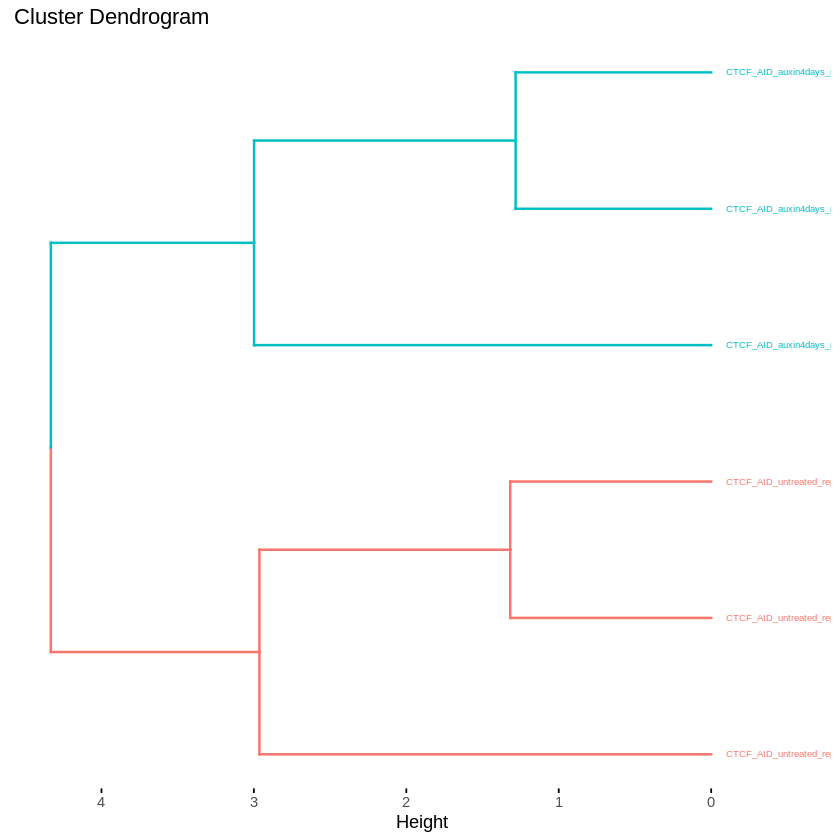

In [23]:
res1 <- hcut(  # hcut 函数是 factoextra 包的函数。hcut 函数通常用于对距离矩阵进行层次聚类，并根据指定的簇数量（在您的示例中是 k = 5）来切割树状图（dendrogram）
    sampleDists,  # 已经计算好的样本间距离矩阵
    k = 2,  # 指定的簇数量，即您希望将数据切割成的群组数量
    blind=T,  # 如果设置为 TRUE，则在切割树状图时不会考虑样本的分组信息（如果有的话），确保聚类的无偏性
    stand = T,  # 标准化参数，如果设置为 TRUE，则在进行聚类之前会对数据进行标准化。在您的代码中，这个选项被设置为 FALSE。
    hc_method =  "complete"# "average"  # 层次聚类中使用的连接方法，例如 "average"（平均连接法），它计算的是群集中所有成员对之间的平均距离。
) 
fviz_dend(  # 来自于 factoextra 包。用于可视化层次聚类的结果
    res1,  # hcut 函数的结果，包含了层次聚类的信息
    rect_fill = F,  # 是否在树状图的每个簇周围绘制矩形框。设置为 FALSE 表示不绘制。
    cex = 0.4,  # 字体大小
    color_labels_by_k=T,  # 是否根据簇的颜色对标签进行着色。设置为 TRUE 表示标签颜色将与其所属簇的颜色相对应
    horiz=T, # 是否水平放置树状图。设置为 TRUE 表示树状图将水平展示
)

In [24]:
pdf("../plots/000_SampleCluster.pdf",width=7,height=7)
fviz_dend(  # 来自于 factoextra 包。用于可视化层次聚类的结果
    res1,  # hcut 函数的结果，包含了层次聚类的信息
    rect_fill = F,  # 是否在树状图的每个簇周围绘制矩形框。设置为 FALSE 表示不绘制。
    cex = 0.4,  # 字体大小
    color_labels_by_k=T,  # 是否根据簇的颜色对标签进行着色。设置为 TRUE 表示标签颜色将与其所属簇的颜色相对应
    horiz=T, # 是否水平放置树状图。设置为 TRUE 表示树状图将水平展示
)
dev.off()

png 
  2

### PCA主成分分析的方法

In [25]:
pdf("../plots/000_PCA_plot.pdf",width=7,height=7)
rld <- vst(dds, blind=FALSE)
#vst()函数效果和rlog（）一样，且速度更快。
plotPCA(rld, intgroup="condition",ntop=500)
dev.off()

using ntop=500 top features by variance



png 
  2

using ntop=500 top features by variance



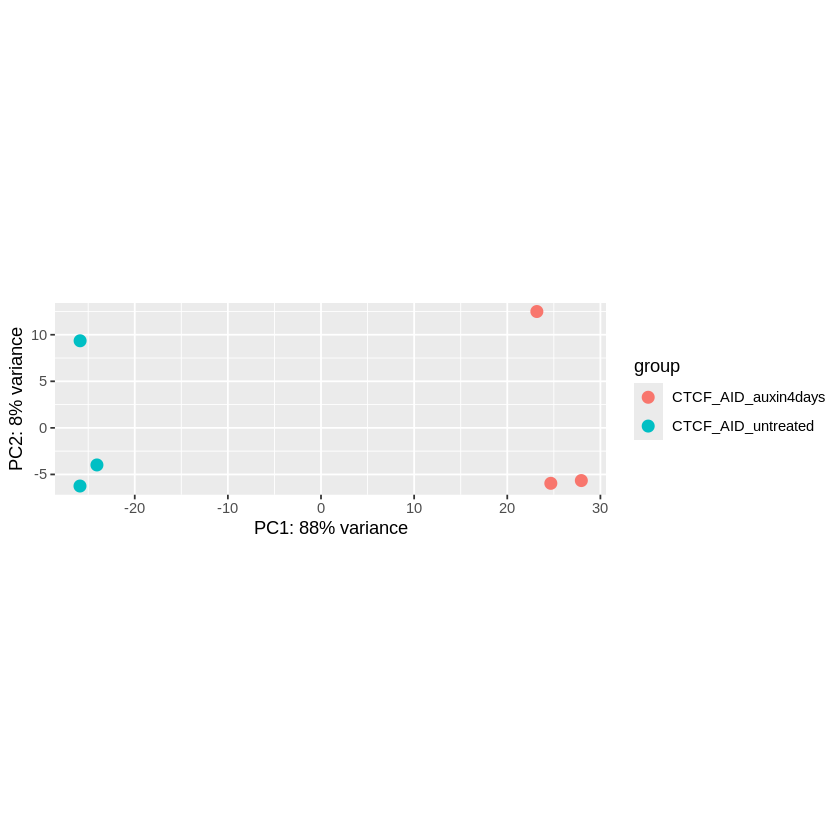

In [26]:
rld <- vst(dds, blind=FALSE)
#vst()函数效果和rlog（）一样，且速度更快。
plotPCA(rld, intgroup="condition",ntop=500)

9. 将dds输入DESeq函数#原始dds进行normalize
DESeq包含三步:
- estimation of size factors（estimateSizeFactors)
- estimation of dispersion（estimateDispersons)
- Negative Binomial GLM fitting and Wald statistics（nbinomWaldTest）
- 【可以分布运行，也可用一步到位，最后返回 results可用的DESeqDataSet对象。】

## 利用DESeq（）函数标准化dds矩阵

In [27]:
dds <- DESeq(dds)
dds

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



class: DESeqDataSet 
dim: 21717 6 
metadata(1): version
assays(4): counts mu H cooks
rownames(21717): ENSMUSG00000051951 ENSMUSG00000102331 ...
  ENSMUSG00000064370 ENSMUSG00000064372
rowData names(22): baseMean baseVar ... deviance maxCooks
colnames(6): CTCF_AID_untreated_rep1 CTCF_AID_untreated_rep2 ...
  CTCF_AID_auxin4days_rep2 CTCF_AID_auxin4days_rep3
colData names(4): sample condition type sizeFactor

In [28]:
resultsNames(dds)

[1] "Intercept"                                          
[2] "condition_CTCF_AID_untreated_vs_CTCF_AID_auxin4days"

In [29]:
dds$condition        #默认后者的处理组比前面的对照组。
# dds$type

[1] CTCF_AID_untreated  CTCF_AID_untreated  CTCF_AID_untreated 
[4] CTCF_AID_auxin4days CTCF_AID_auxin4days CTCF_AID_auxin4days
Levels: CTCF_AID_auxin4days CTCF_AID_untreated

### Dispersion Plot
观察数据的离散情况

- A simple helper function that plots the per-gene dispersion estimates together with the fitted mean-dispersion relationship.

Arguments
- object
   - a DESeqDataSet, with dispersions estimated
- ymin
   - the lower bound for points on the plot, points beyond this are drawn as triangles at ymin
- genecol
   - the color for gene-wise dispersion estimates
- fitcol
   - the color of the fitted estimates
- finalcol
   - the color of the final estimates used for testing
- legend
   - logical, whether to draw a legend
- [文档](https://www.rdocumentation.org/packages/DESeq2/versions/1.12.3/topics/plotDispEsts)

In [30]:
pdf("../plots/001_Dispersion_plot.pdf",width=8,height=8)
plotDispEsts(dds, main="Dispersion plot")
dev.off()

png 
  2

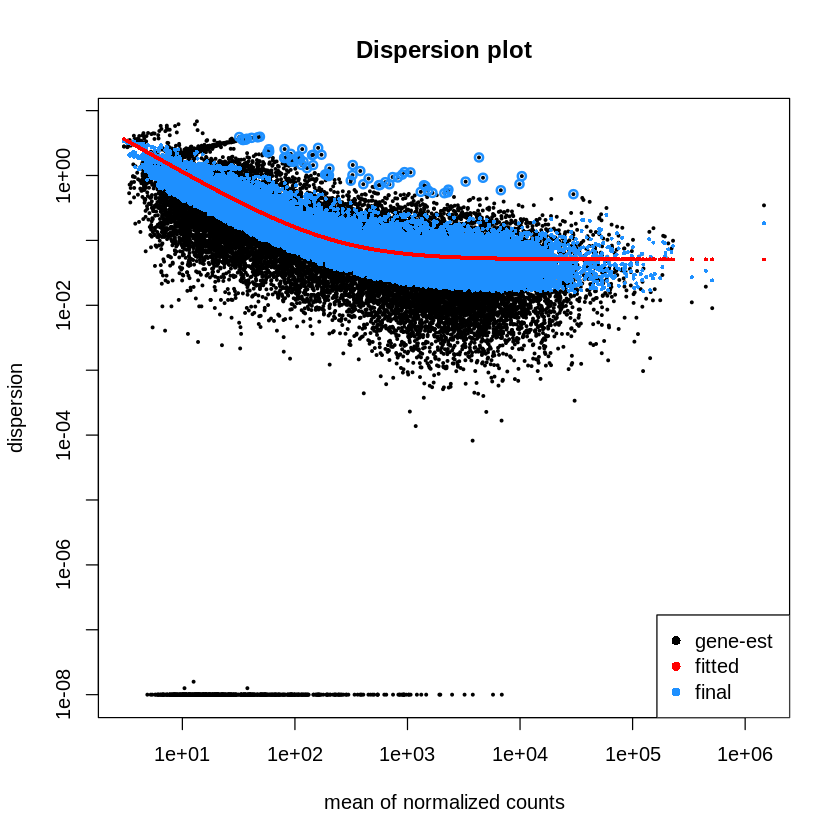

In [31]:
plotDispEsts(dds, main="Dispersion plot")

11. 将结果用results()函数来获取，赋值给res变量

In [32]:
vcmp

[1] "CTCF_AID_auxin4days" "CTCF_AID_untreated"

In [33]:
# 必要步骤！！！
# contrast = c('factorName', 'numeratorLevel', 'denominatorLevel')
# 'factorName' 是你数据集中用于区分不同组别的列名或因子名称。
# 'numeratorLevel' 是你想要比较的那个水平的名称（例如，处理组或实验组）。
# 'denominatorLevel' 是用作比较的基准水平（例如，对照组）。
# res <- results(dds,contrast=c("type", 'treat', 'untreated'))
res <- results(dds,contrast=c("condition", 'CTCF_AID_auxin4days', 'CTCF_AID_untreated'))
# summary一下，看一下结果的概要信息
#看一下结果的概要信息，p值默认小于0.1。
summary(res)


out of 21717 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 3555, 16%
LFC < 0 (down)     : 2731, 13%
outliers [1]       : 1, 0.0046%
low counts [2]     : 843, 3.9%
(mean count < 8)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



## 提取差异分析结果

In [34]:
table(res$padj < 0.05)
#padj 即矫正后的P值。看看有多少差异基因满足所设的P值要求。
# TRUE的数值为满足要求的基因个数。


FALSE  TRUE 
15732  5141 

In [35]:
res <- res[order(res$padj),]
#按照padj 进行升序排列

In [36]:
resdata <- merge(
    as.data.frame(res), 
    as.data.frame(counts(dds, normalized=TRUE)),
    by="row.names",sort=FALSE)

resdata

Row.names,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,CTCF_AID_untreated_rep1,CTCF_AID_untreated_rep2,CTCF_AID_untreated_rep3,CTCF_AID_auxin4days_rep1,CTCF_AID_auxin4days_rep2,CTCF_AID_auxin4days_rep3
<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000026246,540.2447,5.115040,0.2889196,17.70403,3.903726e-70,8.148248e-66,33.282888,35.930537,25.093083,1156.29527,1051.38864,939.47772
ENSMUSG00000112795,812.6084,4.747982,0.2710544,17.51671,1.068182e-68,1.114808e-64,58.245054,59.179709,57.780126,1311.90884,1946.89571,1441.64104
ENSMUSG00000118282,919.0472,3.991726,0.2498394,15.97716,1.843466e-57,1.282622e-53,133.131552,113.075515,88.486136,1776.58824,1875.45000,1527.55198
ENSMUSG00000075707,1014.0179,3.802162,0.2467702,15.40770,1.452906e-53,7.581628e-50,155.320144,120.472978,134.710237,2260.71935,1833.23208,1579.65281
ENSMUSG00000053964,2214.6634,3.798918,0.2502497,15.18051,4.760729e-52,1.987414e-48,324.508158,320.204495,251.591178,3347.85303,5112.42799,3931.39557
ENSMUSG00000034690,973.1151,3.515258,0.2334294,15.05919,3.004566e-51,1.045238e-47,116.490108,185.993370,159.142976,1776.58824,1811.31123,1789.16465
ENSMUSG00000112943,1185.9218,4.065936,0.2703618,15.03887,4.084772e-51,1.218021e-47,135.905126,156.403516,111.598187,1750.65265,2708.44208,2252.52948
ENSMUSG00000079034,6798.9269,4.602766,0.3278436,14.03952,8.931805e-45,2.330420e-41,477.054728,552.696208,580.112467,7192.80495,15652.29461,16338.59842
ENSMUSG00000074365,927.0989,4.263130,0.3046114,13.99531,1.665065e-44,3.861656e-41,138.678700,84.542441,64.713741,1683.65236,1732.55857,1858.44767


12. normalization前面的数据分布差异

In [37]:
### rld normalization ---------------------------------------------------------------------->
# 使用rlogTransformation函数对DESeqDataSet对象dds进行了正则化对数变换（regularized log transformation），这种变换通常用于稳定方差并使得数据更接近正态分布，这在一些后续的数据可视化和探索性分析中很有用。
rld <- rlogTransformation(dds)
rlog_transformed_counts=assay(rld)
n.sample=ncol(rlog_transformed_counts)
if(n.sample>40) par(cex = 0.5)
cols <- rainbow(n.sample*1.2)
# 上一步比较耗时，算数据分布用

### Normalization:

In [38]:
pdf("../plots/002_expression_value_compare.pdf",width = 10, height = 8)
par(mfrow=c(1,2), mar=c(15, 4, 4, 2))
boxplot(raw_counts_select, col = cols,main="expression value\nraw_counts: \nbefore normalization",las=2)
boxplot(rlog_transformed_counts, col = cols,main="expression value\nrlog_transformed_counts: \nafter normalization",las=2)

dev.off()

png 
  2

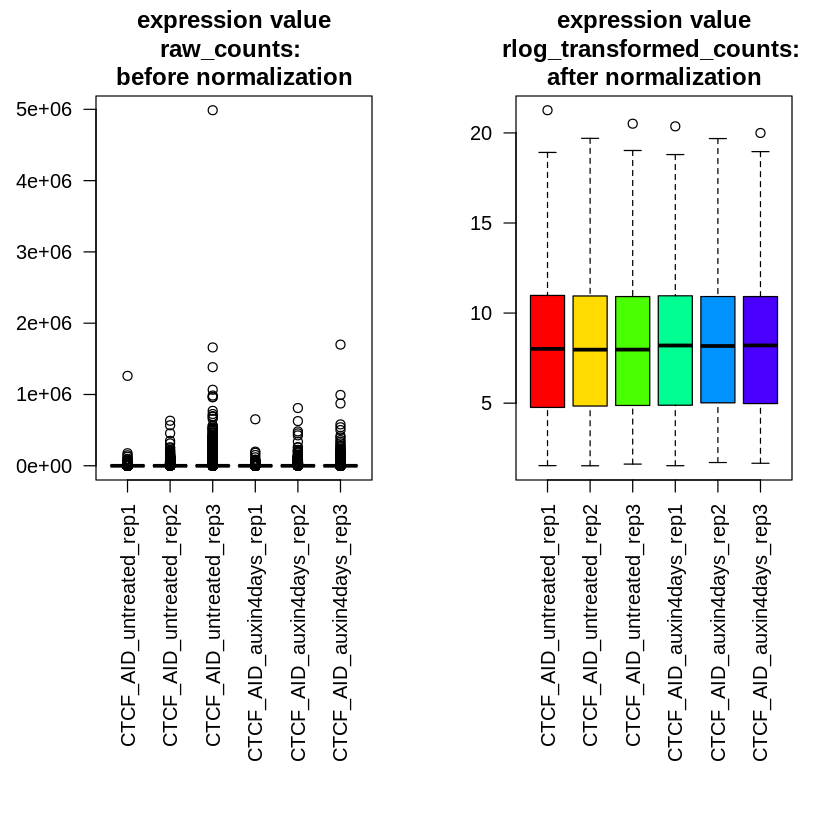

In [39]:
par(mfrow=c(1,2), mar=c(15, 4, 4, 2))
boxplot(raw_counts_select, col = cols,main="expression value\nraw_counts: \nbefore normalization",las=2)
boxplot(rlog_transformed_counts, col = cols,main="expression value\nrlog_transformed_counts: \nafter normalization",las=2)

In [40]:
pdf("../plots/003_expression_distribution_info_hist.pdf",width=8,height=8)
hist(rlog_transformed_counts)
dev.off()

png 
  2

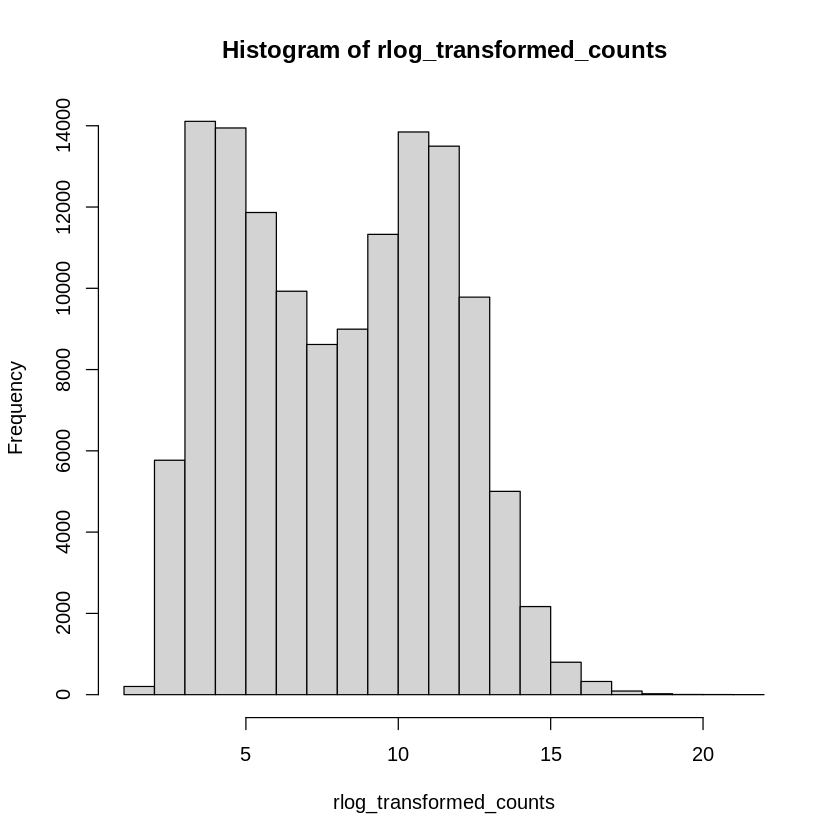

In [41]:
hist(rlog_transformed_counts)

13. plot correlation heatmap

In [42]:
# 查看raw_counts_new
head(rlog_transformed_counts)

,CTCF_AID_untreated_rep1,CTCF_AID_untreated_rep2,CTCF_AID_untreated_rep3,CTCF_AID_auxin4days_rep1,CTCF_AID_auxin4days_rep2,CTCF_AID_auxin4days_rep3
ENSMUSG00000051951,4.872083,5.020587,4.919102,5.216363,5.044732,5.255046
ENSMUSG00000102331,3.534306,3.550168,4.026277,3.520476,4.280862,4.033943
ENSMUSG00000025902,9.968781,9.446692,8.799595,11.067691,10.411498,10.168780
ENSMUSG00000102269,4.038690,3.963045,3.703858,4.507675,4.090600,3.902530
ENSMUSG00000098104,4.486988,4.402682,4.594318,5.022983,4.578019,4.531360
ENSMUSG00000103922,9.567658,9.655856,9.906024,9.276993,9.420135,9.510938


In [43]:
### plot correlation heatmap -------------------------------------------------------------->
(mycols <- brewer.pal(8, "Dark2")[1:length(unique(column_info$type))])
# Sample distance heatmap
sampleDists <- dist(t(rlog_transformed_counts))
sampleDistsMatrix <- as.matrix(sampleDists)
head(sampleDistsMatrix)

[1] "#1B9E77" "#D95F02"

,CTCF_AID_untreated_rep1,CTCF_AID_untreated_rep2,CTCF_AID_untreated_rep3,CTCF_AID_auxin4days_rep1,CTCF_AID_auxin4days_rep2,CTCF_AID_auxin4days_rep3
CTCF_AID_untreated_rep1,0.00000,50.70971,56.30268,76.79589,82.50109,81.91107
CTCF_AID_untreated_rep2,50.70971,0.00000,28.92748,84.60578,71.19992,70.71061
CTCF_AID_untreated_rep3,56.30268,28.92748,0.00000,90.95632,75.12554,70.15102
CTCF_AID_auxin4days_rep1,76.79589,84.60578,90.95632,0.00000,53.37397,58.10555
CTCF_AID_auxin4days_rep2,82.50109,71.19992,75.12554,53.37397,0.00000,29.23677
CTCF_AID_auxin4days_rep3,81.91107,70.71061,70.15102,58.10555,29.23677,0.00000


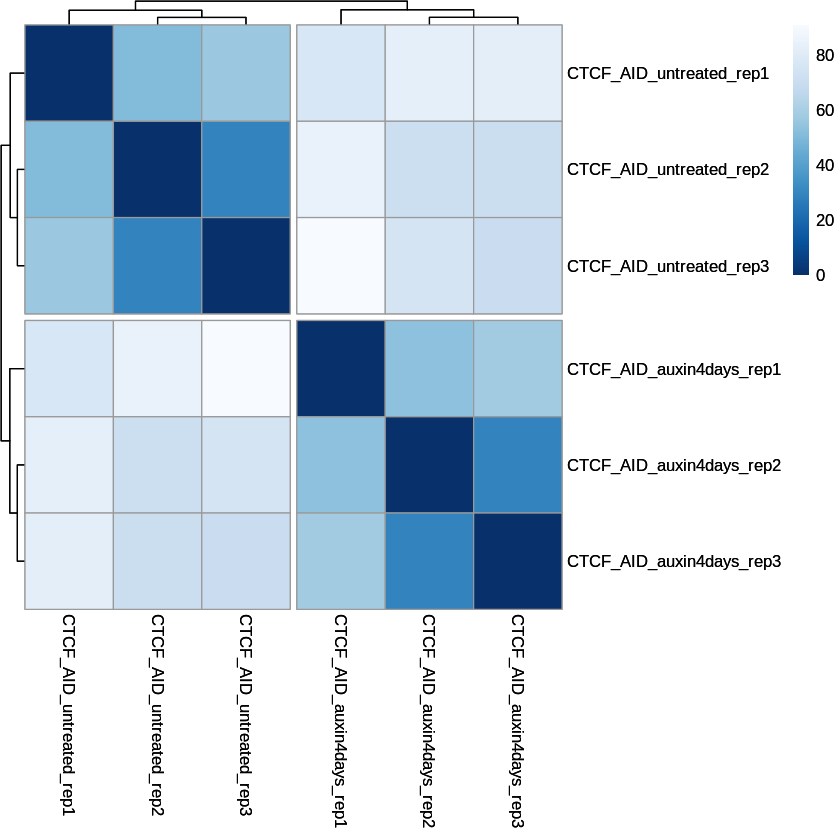

In [44]:
colors <- colorRampPalette(rev(brewer.pal(9,"Blues")))(255)  # brewer.pal来自RColorBrewer包
ht <- pheatmap(
    sampleDistsMatrix,
    clustering_cols = FALSE,  # 禁止列聚类  
    clustering_rows = FALSE,  # 禁止行聚类 
    treeheight_row = 10,
    treeheight_col = 10,
    cutree_rows = 2, 
    cutree_cols = 2,
    clustering_distance_cols = sampleDists,
    clustering_distance_rows = sampleDists,
    color = colors,   
    display_numbers = F,   # 显示数字  
    number_format = "%.2f",   # 设置数字的格式  
    number_color = "black",   # 设置数字的颜色  
    fontsize = 10,            # 设置字体大小  
    # filename = "../plots/004_correlation_cross_samples_heatmap.pdf"  # 如果需要保存图像，设置文件名
)
ht

In [45]:
pdf("../plots/004_correlation_cross_samples_heatmap.pdf",width = 6, height = 6)
ht
dev.off()

png 
  2

14. MA plot
- log2 折叠变换和平均正常统计量的关系，红色的点表示在10%FDR的基因

In [46]:
### MA plot ------------------------------------------------------------------------------>
pdf("../plots/005_DESeq2_MA_plot.pdf",width = 8, height = 8)
par(mfrow=c(1,1))
DESeq2::plotMA(res, main="DESeq2", ylim=c(-20,20))
dev.off()

png 
  2

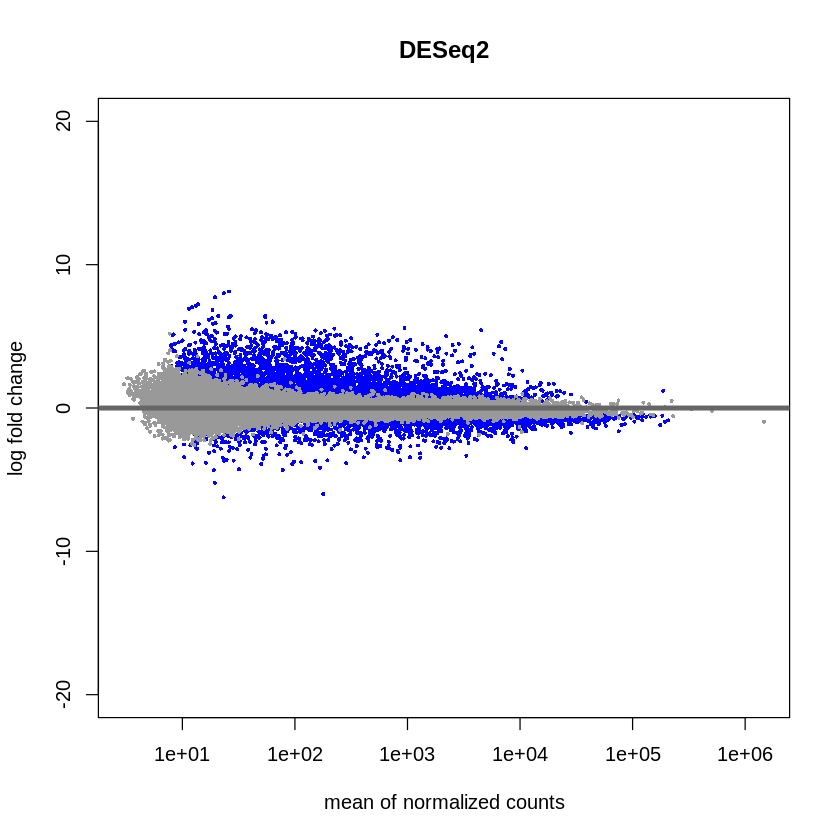

In [47]:
par(mfrow=c(1,1))
DESeq2::plotMA(res, main="DESeq2", ylim=c(-20,20))

15. nbinomTest的p值统计直方图

In [48]:
pdf("../plots/006_nbinomTest_p_value.pdf",width = 8, height = 8)
hist(res$pvalue, breaks = 100, col = 'skyblue', border = 'slateblue', main = 'nbinomTest p value')
dev.off()

png 
  2

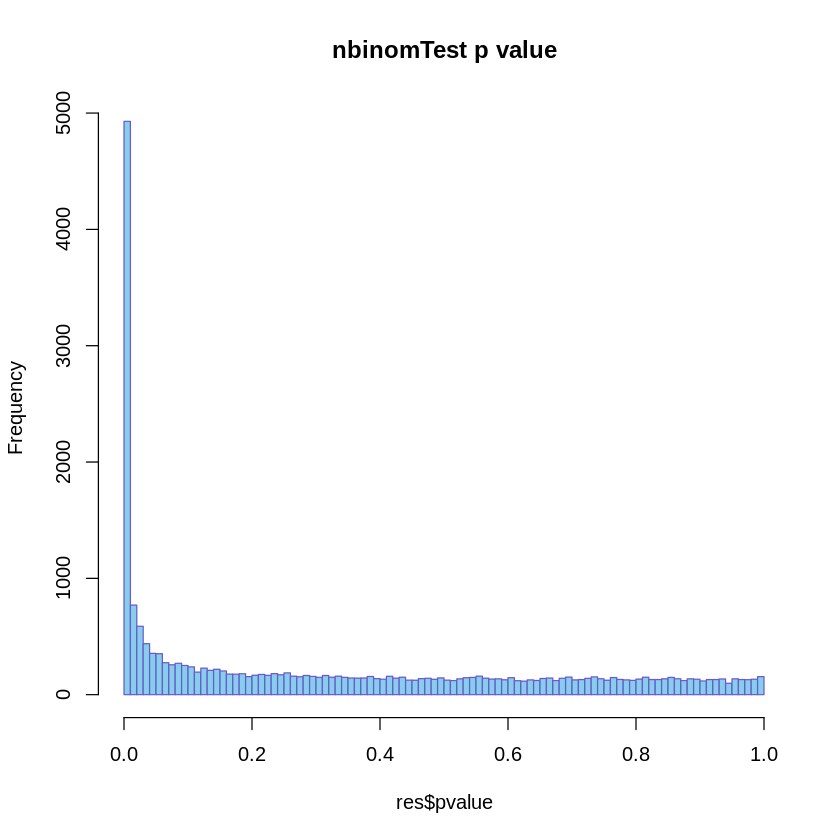

In [49]:
hist(res$pvalue, breaks = 100, col = 'skyblue', border = 'slateblue', main = 'nbinomTest p value')

17. 这个heatmap干嘛的？

In [50]:
d <- plotCounts(dds,gene=which.min(res$padj), intgroup = "condition",returnData = TRUE)

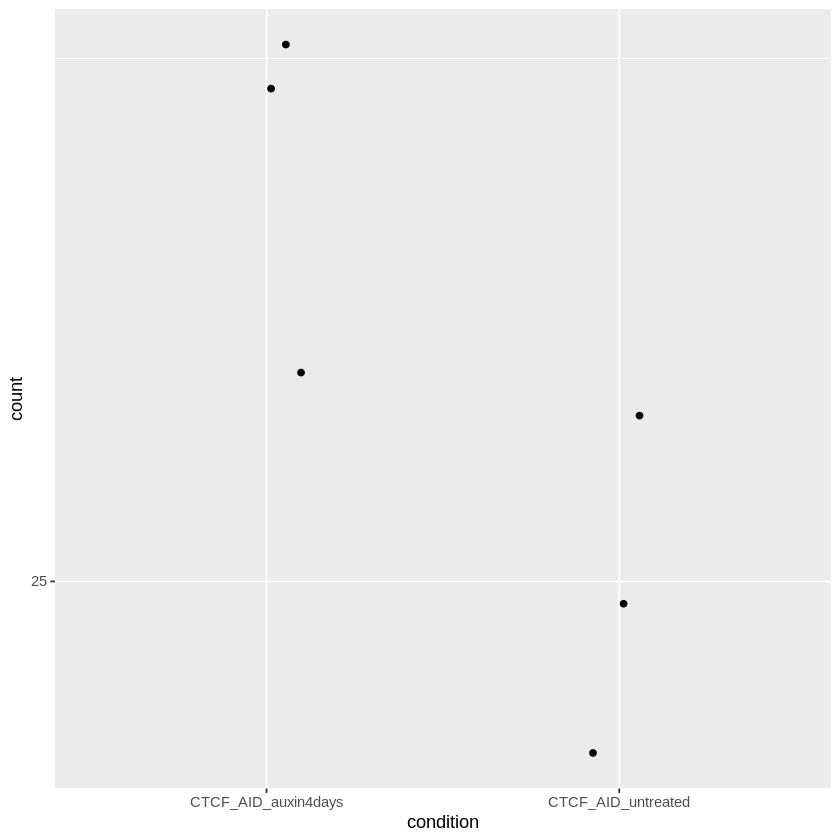

In [51]:
g <- ggplot(d,aes(x=condition,y=count)) +
    geom_point(position = position_jitter(w=0.1,h=0)) +
    scale_y_log10(breaks=c(25,100,400))
g

In [52]:
ggsave("../plots/007_jitter_plot_for_min_pvalue_transcript_counts.pdf", g, height = 8, width = 8)

18. 处理res数据并且输出DEG表格

In [53]:
### deal with res and extract DEG!!! ----------------------------------------------------->
# 标准cutoff
log2fc = 1  # >=1
pv = 0.05  # <=0.05
# 松cutoff
# log2fc = 1  # >=1
# pv = 1  # <=0.05


resOrdered <- res[order(res$padj),]
resOrdered[which(resOrdered$log2FoldChange >= log2fc & resOrdered$pvalue<pv), 'sig'] <- 'up'
resOrdered[which(resOrdered$log2FoldChange <= -log2fc & resOrdered$pvalue<pv),'sig'] <- 'down'
resOrdered[which(abs(resOrdered$log2FoldChange) <= log2fc & resOrdered$pvalue>=pv),'sig'] <- 'none'
resOrdered=as.data.frame(resOrdered)

write.table(resOrdered,"../plots/deseq2.all_sample.results.csv",col.names = NA, sep = ",", quote = FALSE)

deg <- subset(resOrdered, (abs(resOrdered$log2FoldChange) >=log2fc & resOrdered$padj<pv)) ##### extract DEG !

deg_matrix <- as.data.frame(deg)
write.table(deg_matrix, '../plots/deg_result.csv', col.names = NA, sep = ",", quote = FALSE)


# raw count norm by deseq2
write.table(rlog_transformed_counts, '../plots/raw_counts_norm_by_DESeq2.csv', col.names = NA, sep = ",", quote = FALSE)

print(dim(deg))
deg

[1] 3280    7


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,sig
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSMUSG00000026246,540.2447,5.115040,0.2889196,17.70403,3.903726e-70,8.148248e-66,up
ENSMUSG00000112795,812.6084,4.747982,0.2710544,17.51671,1.068182e-68,1.114808e-64,up
ENSMUSG00000118282,919.0472,3.991726,0.2498394,15.97716,1.843466e-57,1.282622e-53,up
ENSMUSG00000075707,1014.0179,3.802162,0.2467702,15.40770,1.452906e-53,7.581628e-50,up
ENSMUSG00000053964,2214.6634,3.798918,0.2502497,15.18051,4.760729e-52,1.987414e-48,up
ENSMUSG00000034690,973.1151,3.515258,0.2334294,15.05919,3.004566e-51,1.045238e-47,up
ENSMUSG00000112943,1185.9218,4.065936,0.2703618,15.03887,4.084772e-51,1.218021e-47,up
ENSMUSG00000079034,6798.9269,4.602766,0.3278436,14.03952,8.931805e-45,2.330420e-41,up
ENSMUSG00000074365,927.0989,4.263130,0.3046114,13.99531,1.665065e-44,3.861656e-41,up


In [54]:
table(deg$sig)


down   up 
 844 2436 

In [55]:
### plot heatmap ------------------------------------------------------------------------->
### plot all genes heatmap
select <- order(rowMeans(counts(dds,normalized=TRUE)),
                decreasing=TRUE)[1:1000]  ### select first ordered 1000 genes(not deg)
                # decreasing=TRUE)[1:50]  ### select first ordered 66 genes(not deg)
head(assay(rld)[select,])

,CTCF_AID_untreated_rep1,CTCF_AID_untreated_rep2,CTCF_AID_untreated_rep3,CTCF_AID_auxin4days_rep1,CTCF_AID_auxin4days_rep2,CTCF_AID_auxin4days_rep3
ENSMUSG00000106106,21.26058,19.69971,20.51264,20.36537,19.68692,19.99730
ENSMUSG00000037742,18.91710,19.10917,19.02432,18.79957,18.95543,18.90970
ENSMUSG00000064351,18.68441,18.83496,18.78628,18.65084,18.64612,18.96110
ENSMUSG00000023944,18.40075,18.44311,18.30601,18.33023,18.44353,18.18313
ENSMUSG00000021270,17.50329,18.13202,18.08732,17.21165,17.70965,17.73969
ENSMUSG00000064341,17.25286,17.61110,17.77408,17.56919,17.93907,18.09303


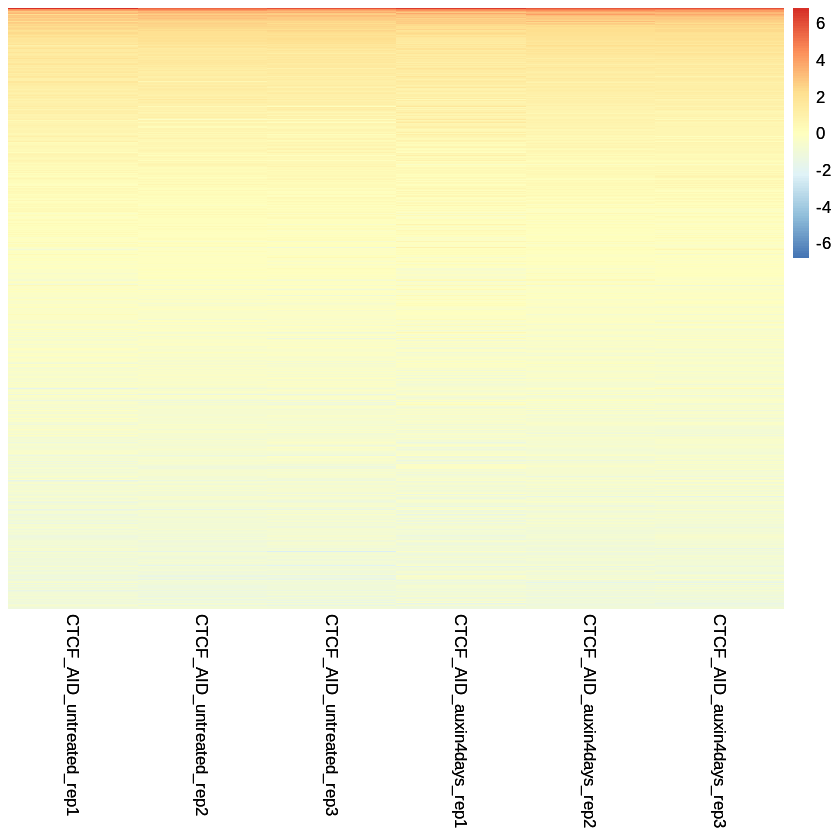

In [56]:
p1000 <- pheatmap(assay(rld)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE,scale = "column")
p1000

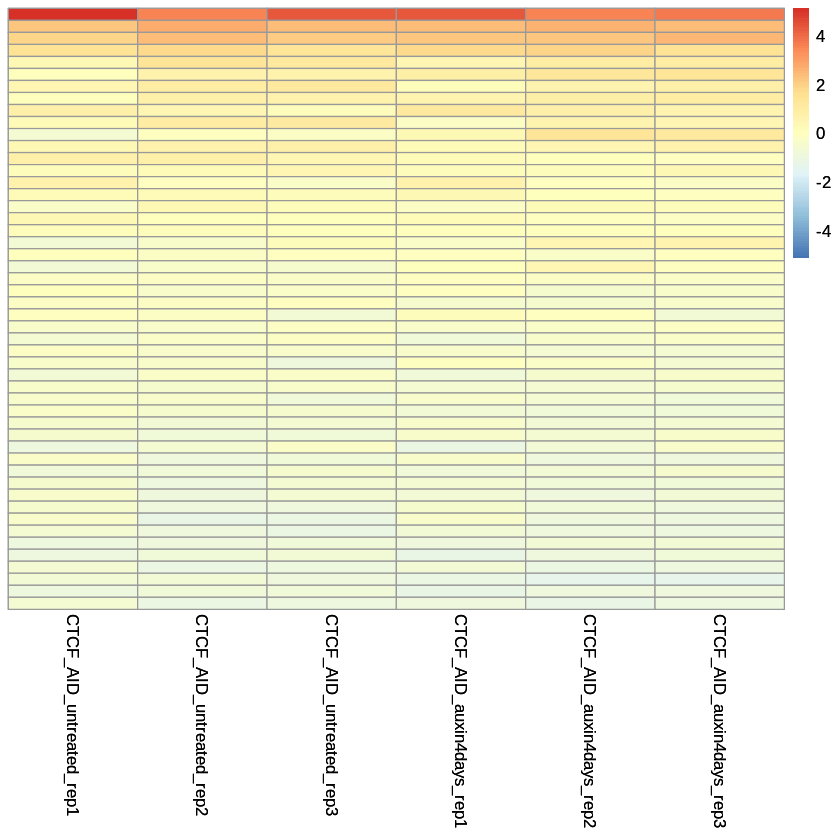

In [57]:
select <- order(rowMeans(counts(dds,normalized=TRUE)),
#                 decreasing=TRUE)[1:1000]  ### select first ordered 1000 genes(not deg)
                decreasing=TRUE)[1:50]  ### select first ordered 66 genes(not deg)
p50 <- pheatmap(assay(rld)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE,scale = "column")
p50

In [58]:
pdf("../plots/008_select_first_ordered_1000_transcriptsOrGenes_plot_heatmap.pdf",height = 10,width = 10)
p1000
dev.off()
pdf("../plots/009_select_first_ordered_50_transcriptsOrGenes_plot_heatmap.pdf",height = 10,width = 10)
p50
dev.off()

png 
  2

png 
  2

In [59]:
# rownames(deg)

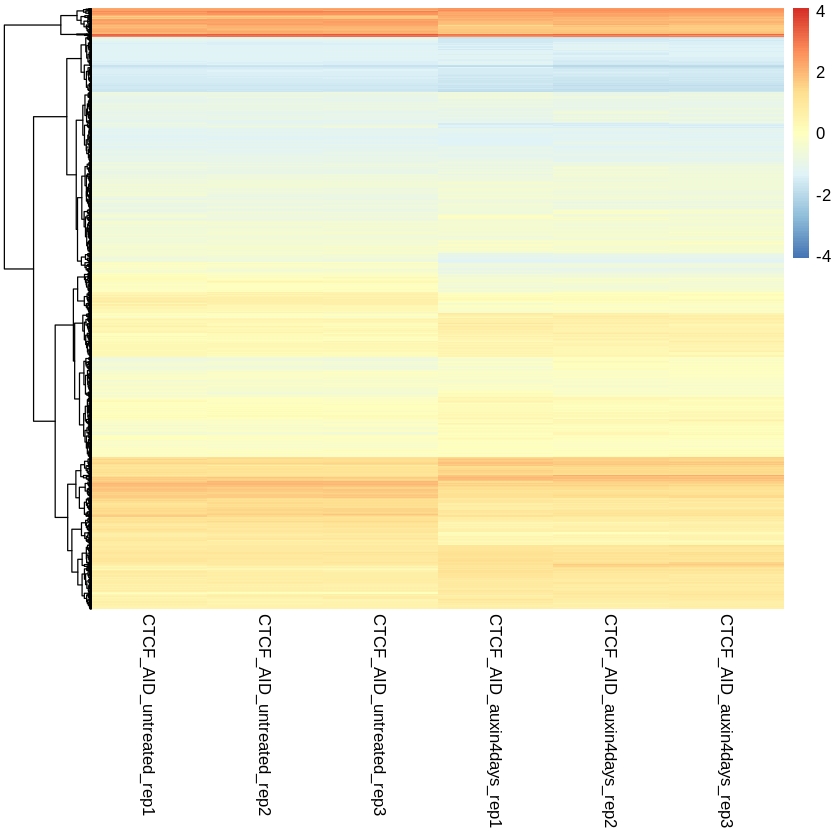

In [60]:
### plot DEG heatmap
selected <- rownames(deg)
pDEG <- pheatmap(
    assay(rld)[rownames(rld) %in% selected,], 
    # show_rownames=TRUE,
    cluster_rows=TRUE, 
    show_rownames=FALSE,
    cluster_cols=FALSE, 
    scale = "column",
)

In [61]:
pdf("../plots/010_select_differential_expression_genes_heatmap.pdf",height = 10,width = 10)
pDEG
dev.off()

png 
  2

In [62]:
resOrdered

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,sig
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSMUSG00000026246,540.2447,5.115040,0.2889196,17.70403,3.903726e-70,8.148248e-66,up
ENSMUSG00000112795,812.6084,4.747982,0.2710544,17.51671,1.068182e-68,1.114808e-64,up
ENSMUSG00000118282,919.0472,3.991726,0.2498394,15.97716,1.843466e-57,1.282622e-53,up
ENSMUSG00000075707,1014.0179,3.802162,0.2467702,15.40770,1.452906e-53,7.581628e-50,up
ENSMUSG00000053964,2214.6634,3.798918,0.2502497,15.18051,4.760729e-52,1.987414e-48,up
ENSMUSG00000034690,973.1151,3.515258,0.2334294,15.05919,3.004566e-51,1.045238e-47,up
ENSMUSG00000112943,1185.9218,4.065936,0.2703618,15.03887,4.084772e-51,1.218021e-47,up
ENSMUSG00000079034,6798.9269,4.602766,0.3278436,14.03952,8.931805e-45,2.330420e-41,up
ENSMUSG00000074365,927.0989,4.263130,0.3046114,13.99531,1.665065e-44,3.861656e-41,up


Warning message:
“Removed 849 rows containing missing values or values outside the scale range
(`geom_point()`).”


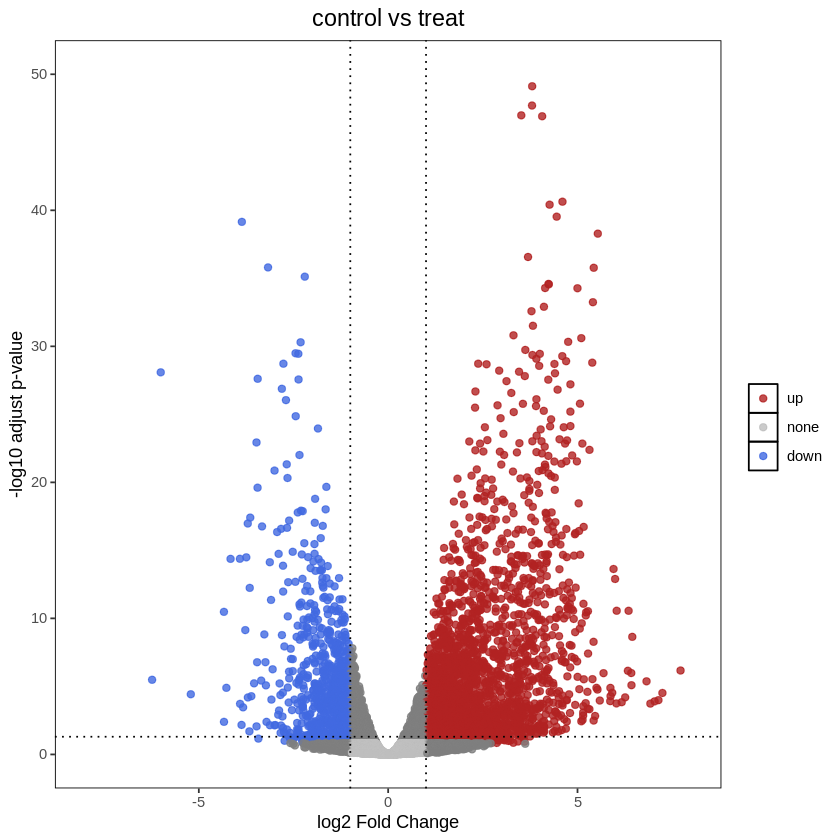

In [63]:
### plot valcano ------------------------------------------------------------------------>
vp <- ggplot(data = resOrdered, aes(x = log2FoldChange, y = -log10(padj),color = sig)) +
  geom_point(size = 1.7, alpha=0.8) +  #绘制散点图
  scale_color_manual(values = c('#B22222', 'gray', '#4169E1'), limits = c('up', 'none', 'down')) +  #自定义点的颜色
  labs(x = 'log2 Fold Change', y = '-log10 adjust p-value', title = 'control vs treat', color = '') +  #坐标轴标题
  theme(plot.title = element_text(hjust = 0.5, size = 14), panel.grid = element_blank(), #背景色、网格线、图例等主题修改
        panel.background = element_rect(color = 'black', fill = 'transparent'),
        legend.key = element_rect(fill = 'transparent')) +
  geom_vline(xintercept = c(-1, 1), lty = 3, color = 'black') +  #添加阈值线
  geom_hline(yintercept = 1.3, lty = 3, color = 'black') +
  # xlim(-2, 2) + ylim(0, 5)
  xlim(-8, 8) + ylim(0, 50)

vp

In [64]:
pdf("../plots/011_select_differential_expression_genes_valcano_plot.pdf",height = 8,width = 8)
vp
dev.off()

Warning message:
“Removed 849 rows containing missing values or values outside the scale range
(`geom_point()`).”


png 
  2

# 转换所有基因名和差异表达基因名

In [101]:
deg_res <- read_csv("../plots/deg_result.csv")
all_res <- read_csv("../plots/deseq2.all_sample.results.csv")
colnames(deg_res)[1] <- "ENSEMBL_name"
colnames(all_res)[1] <- "ENSEMBL_name"

New names:
• `` -> `...1`
Rows: 3280 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): ...1, sig
dbl (6): baseMean, log2FoldChange, lfcSE, stat, pvalue, padj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 21717 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): ...1, sig
dbl (6): baseMean, log2FoldChange, lfcSE, stat, pvalue, padj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [102]:
head(deg_res)

ENSEMBL_name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSMUSG00000026246,540.2447,5.115040,0.2889196,17.70403,3.903726e-70,8.148248e-66,up
ENSMUSG00000112795,812.6084,4.747982,0.2710544,17.51671,1.068182e-68,1.114808e-64,up
ENSMUSG00000118282,919.0472,3.991726,0.2498394,15.97716,1.843466e-57,1.282622e-53,up
ENSMUSG00000075707,1014.0179,3.802162,0.2467702,15.40770,1.452906e-53,7.581628e-50,up
ENSMUSG00000053964,2214.6634,3.798918,0.2502497,15.18051,4.760729e-52,1.987414e-48,up
ENSMUSG00000034690,973.1151,3.515258,0.2334294,15.05919,3.004566e-51,1.045238e-47,up


```
git clone https://github.com/xuzhougeng/org.At.tair.db.git
cd org.At.tair.db
Rscript org.At.tair.db.R
```

In [103]:
library(AnnotationDbi)
library(org.Mm.eg.db)
library(clusterProfiler)

In [104]:
deg_anno <- AnnotationDbi::mapIds(
    org.Mm.eg.db, 
    keys=as.vector(deg_res$ENSEMBL_name), 
    column="SYMBOL", 
    keytype="ENSEMBL"
)
deg_res_final <- deg_res %>% add_column(
    deg_anno,
    .after="ENSEMBL_name",
)
colnames(deg_res_final)[2] <- "SYMBOL_name"
head(deg_res_final)

'select()' returned 1:many mapping between keys and columns



ENSEMBL_name,SYMBOL_name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,sig
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSMUSG00000026246,Alppl2,540.2447,5.115040,0.2889196,17.70403,3.903726e-70,8.148248e-66,up
ENSMUSG00000112795,NA,812.6084,4.747982,0.2710544,17.51671,1.068182e-68,1.114808e-64,up
ENSMUSG00000118282,Gm4840,919.0472,3.991726,0.2498394,15.97716,1.843466e-57,1.282622e-53,up
ENSMUSG00000075707,Dio3,1014.0179,3.802162,0.2467702,15.40770,1.452906e-53,7.581628e-50,up
ENSMUSG00000053964,Lgals4,2214.6634,3.798918,0.2502497,15.18051,4.760729e-52,1.987414e-48,up
ENSMUSG00000034690,Nlrp4c,973.1151,3.515258,0.2334294,15.05919,3.004566e-51,1.045238e-47,up


In [105]:
all_anno <- AnnotationDbi::mapIds(
    org.Mm.eg.db, 
    keys=as.vector(all_res$ENSEMBL_name), 
    column="SYMBOL", 
    keytype="ENSEMBL"
)
all_res_final <- all_res %>% add_column(
    all_anno,
    .after="ENSEMBL_name",
)
colnames(all_res_final)[2] <- "SYMBOL_name"
head(all_res_final)

'select()' returned 1:many mapping between keys and columns



ENSEMBL_name,SYMBOL_name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,sig
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSMUSG00000026246,Alppl2,540.2447,5.115040,0.2889196,17.70403,3.903726e-70,8.148248e-66,up
ENSMUSG00000112795,NA,812.6084,4.747982,0.2710544,17.51671,1.068182e-68,1.114808e-64,up
ENSMUSG00000118282,Gm4840,919.0472,3.991726,0.2498394,15.97716,1.843466e-57,1.282622e-53,up
ENSMUSG00000075707,Dio3,1014.0179,3.802162,0.2467702,15.40770,1.452906e-53,7.581628e-50,up
ENSMUSG00000053964,Lgals4,2214.6634,3.798918,0.2502497,15.18051,4.760729e-52,1.987414e-48,up
ENSMUSG00000034690,Nlrp4c,973.1151,3.515258,0.2334294,15.05919,3.004566e-51,1.045238e-47,up


In [106]:
write_csv(deg_res_final,"../plots/deg_result_symbol.csv")
write_csv(all_res_final,"../plots/all_result_symbol.csv")

In [107]:
genes_up = deg_res_final %>% filter(sig=='up') %>% select(ENSEMBL_name) %>% as_vector()
genes_down = deg_res_final %>% filter(sig=='down') %>% select(ENSEMBL_name) %>% as_vector()

In [108]:
genes_up_all_types <- bitr(
    genes_up, 
    fromType="ENSEMBL", 
    toType=c(
        "ENTREZID",
        "ENSEMBL",
        "SYMBOL"
    ), 
    OrgDb="org.Mm.eg.db"
)
head(genes_up_all_types)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(genes_up, fromType = "ENSEMBL", toType = c("ENTREZID", "ENSEMBL", :
“11.45% of input gene IDs are fail to map...”


,ENSEMBL,ENTREZID,SYMBOL
,<chr>,<chr>,<chr>
1,ENSMUSG00000026246,11650,Alppl2
3,ENSMUSG00000118282,225468,Gm4840
4,ENSMUSG00000075707,107585,Dio3
5,ENSMUSG00000053964,16855,Lgals4
6,ENSMUSG00000034690,83564,Nlrp4c
8,ENSMUSG00000079034,666806,Eif1ad8


In [109]:
genes_down_all_types <- bitr(
    genes_down, 
    fromType="ENSEMBL", 
    toType=c(
        "ENTREZID",
        "ENSEMBL",
        "SYMBOL"
    ), 
    OrgDb="org.Mm.eg.db"
)
head(genes_down_all_types)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(genes_down, fromType = "ENSEMBL", toType = c("ENTREZID", :
“10.31% of input gene IDs are fail to map...”


,ENSEMBL,ENTREZID,SYMBOL
,<chr>,<chr>,<chr>
1,ENSMUSG00000039765,231214,Cc2d2a
2,ENSMUSG00000022101,14171,Fgf17
3,ENSMUSG00000030060,232210,Hmces
4,ENSMUSG00000042747,66059,Krtcap2
5,ENSMUSG00000006457,11474,Actn3
6,ENSMUSG00000000409,16818,Lck


In [110]:
goALL <- enrichGO(genes_up_all_types$ENTREZID,OrgDb = org.Mm.eg.db, ont='ALL',pAdjustMethod = 'BH',pvalueCutoff = 0.5, keyType='ENTREZID')
head(goALL)

,ONTOLOGY,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0030198,BP,GO:0030198,extracellular matrix organization,89/2020,322/28891,3.522904e-30,1.134392e-26,6.543250e-27,18214/13078/14219/16780/71602/56373/16917/18858/19645/18826/13710/12842/66214/208177/69700/16007/69538/12832/12831/114249/104009/16416/14238/108153/12156/12825/17183/11785/12306/21938/12836/23871/12843/399558/17388/17300/17127/68553/76293/14726/12837/17880/241639/16948/53867/12827/107581/17390/12826/545370/11595/13138/229595/64074/74199/21808/16950/19288/13717/21937/213945/12390/13805/16147/14186/14234/235130/20319/320078/18595/382864/545893/12839/17180/81877/15227/16772/67573/12815/20724/546144/12830/23794/15530/12840/57764/23876/224224/170721,89
GO:0045229,BP,GO:0045229,external encapsulating structure organization,89/2020,323/28891,4.538635e-30,1.134392e-26,6.543250e-27,18214/13078/14219/16780/71602/56373/16917/18858/19645/18826/13710/12842/66214/208177/69700/16007/69538/12832/12831/114249/104009/16416/14238/108153/12156/12825/17183/11785/12306/21938/12836/23871/12843/399558/17388/17300/17127/68553/76293/14726/12837/17880/241639/16948/53867/12827/107581/17390/12826/545370/11595/13138/229595/64074/74199/21808/16950/19288/13717/21937/213945/12390/13805/16147/14186/14234/235130/20319/320078/18595/382864/545893/12839/17180/81877/15227/16772/67573/12815/20724/546144/12830/23794/15530/12840/57764/23876/224224/170721,89
GO:0043062,BP,GO:0043062,extracellular structure organization,89/2020,324/28891,5.840358e-30,1.134392e-26,6.543250e-27,18214/13078/14219/16780/71602/56373/16917/18858/19645/18826/13710/12842/66214/208177/69700/16007/69538/12832/12831/114249/104009/16416/14238/108153/12156/12825/17183/11785/12306/21938/12836/23871/12843/399558/17388/17300/17127/68553/76293/14726/12837/17880/241639/16948/53867/12827/107581/17390/12826/545370/11595/13138/229595/64074/74199/21808/16950/19288/13717/21937/213945/12390/13805/16147/14186/14234/235130/20319/320078/18595/382864/545893/12839/17180/81877/15227/16772/67573/12815/20724/546144/12830/23794/15530/12840/57764/23876/224224/170721,89
GO:0007389,BP,GO:0007389,pattern specification process,110/2020,498/28891,9.768957e-28,1.423093e-24,8.208495e-25,19378/15394/15375/16917/12151/17702/20890/14164/13614/11819/14766/100121/13641/15422/17701/12153/69327/240888/15110/232174/15214/16372/12156/212712/226049/110796/15437/76365/18423/654470/21813/15417/22420/240590/20613/22415/17300/14836/17127/23805/12227/16658/13392/18530/17268/15427/68151/18186/57246/12705/70028/19165/17965/21380/20472/15412/13796/21385/320145/15376/18505/18121/18741/22421/235320/13805/16373/16147/14186/14234/21869/83675/12590/15228/11482/15438/16814/20319/20671/22422/18088/13390/12162/17537/13388/13082/54713/20348/14463/15227/22771/209448/22255/242620/15425/15431/68270/75691/12022/20465/12266/16870/15423/15424/14451/21386/17684/11835/15400/19434,110
GO:0061448,BP,GO:0061448,connective tissue development,84/2020,316/28891,2.940032e-27,3.426313e-24,1.976320e-24,14219/208647/13601/18596/16194/21825/15375/17702/19645/76566/12111/14462/13614/12842/17701/12153/216795/16007/12831/16416/108153/15110/12156/12023/12825/212712/216616/58250/15364/218772/242316/21813/20613/18605/13521/17127/12164/230103/107587/73121/13392/12977/18027/20583/16948/12394/14284/13592/19228/15904/11595/18133/20472/21808/13549/15376/16000/18121/22421/108012/235320/16147/14234/20319/22422/12162/12839/17180/12815/22255/15431/319197/15485/15530/20378/14180/20429/15423/56788/20375/14756/15400/18159/20681,84
GO:0048705,BP,GO:0048705,skeletal system morphogenesis,73/2020,266/28891,8.952683e-25,8.694548e-22,5.015073e-22,668137/14219/15394/18596/21825/12151/17702/76566/20397/12842/15586/17701/216795/18439/232174/12023/12825/212712/58250/98711/15437/218772/22337/21813/15417/18605/21387/17300/14836/17127/230103/107587/73121/13392/17002/114873/14284/11433/15427/17390/20148/11595/14260/22412/21380/20472/15412/21808/18121/2

In [111]:
table(goALL$ONTOLOGY)


  BP   CC   MF 
3696  220  420 

In [112]:
pdf("../plots/012_GO_UP_BP.pdf",height = 12,width = 8)
dotplot(goALL %>% filter(ONTOLOGY=="BP"), showCategory=20)#气泡图
dev.off()

png 
  2

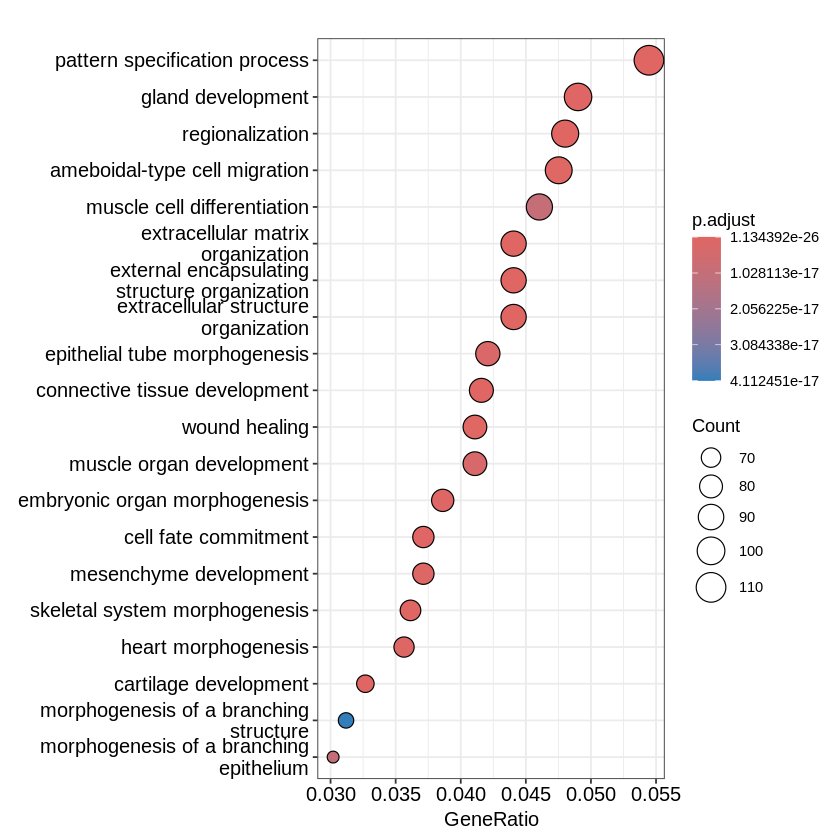

In [113]:
dotplot(goALL %>% filter(ONTOLOGY=="BP"), showCategory=20)#气泡图

In [114]:
pdf("../plots/012_GO_UP_CC.pdf",height = 12,width = 8)
dotplot(goALL %>% filter(ONTOLOGY=="CC"), showCategory=20)#气泡图
dev.off()

png 
  2

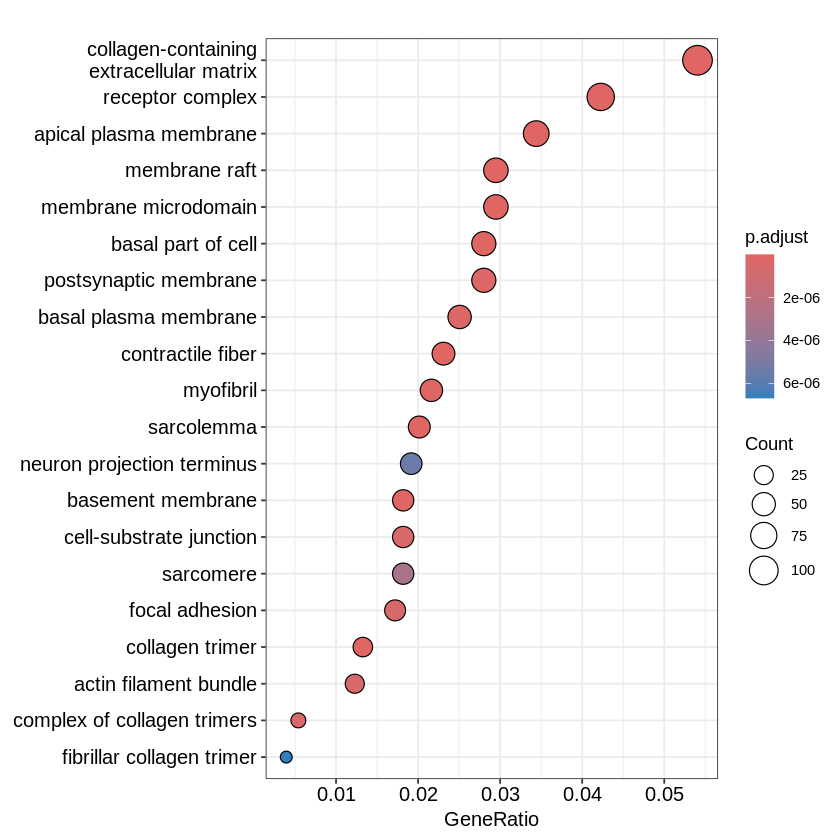

In [115]:
dotplot(goALL %>% filter(ONTOLOGY=="CC"), showCategory=20)#气泡图

In [116]:
pdf("../plots/012_GO_UP_MF.pdf",height = 12,width = 8)
dotplot(goALL %>% filter(ONTOLOGY=="MF"), showCategory=20)#气泡图
dev.off()

png 
  2

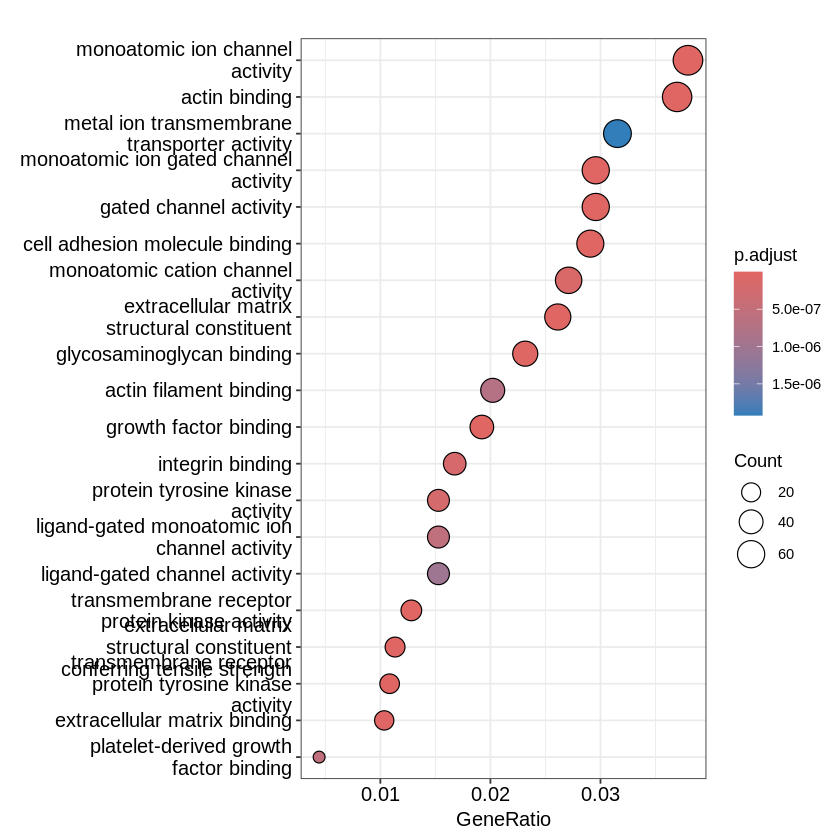

In [117]:
dotplot(goALL %>% filter(ONTOLOGY=="MF"), showCategory=20)#气泡图

In [118]:
pdf("../plots/012_GO_UP_merge.pdf",height = 12,width = 8)
dotplot(goALL, split="ONTOLOGY", showCategory=6) + facet_grid(ONTOLOGY~.,scale="free")
dev.off()

png 
  2

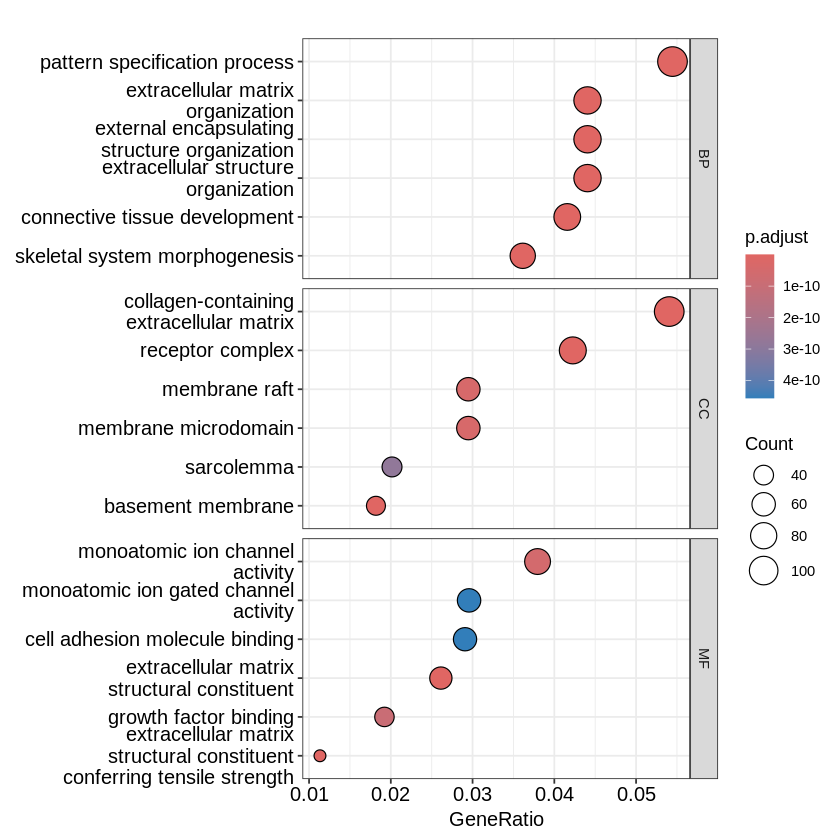

In [119]:
dotplot(goALL, split="ONTOLOGY", showCategory=6) + facet_grid(ONTOLOGY~.,scale="free")

In [120]:
goALL <- enrichGO(genes_down_all_types$ENTREZID,OrgDb = org.Mm.eg.db, ont='ALL',pAdjustMethod = 'BH',pvalueCutoff = 0.5, keyType='ENTREZID')
head(goALL)

,ONTOLOGY,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0006520,BP,GO:0006520,amino acid metabolic process,28/708,272/28891,1.951285e-10,9.157382e-07,7.221810e-07,30956/16467/381411/108682/107272/14719/70223/14584/107045/109652/14450/100678/20226/104458/12036/226539/216456/14711/20540/18127/242642/56454/19125/20512/26912/214579/71776/64705,28
GO:0006007,BP,GO:0006007,glucose catabolic process,9/708,26/28891,6.520200e-09,1.529965e-05,1.206580e-05,11474/16828/13806/18746/56421/21991/18655/103988/433182,9
GO:0006090,BP,GO:0006090,pyruvate metabolic process,17/708,137/28891,4.688833e-08,7.334898e-05,5.784539e-05,11474/16828/228026/80879/13806/18746/18519/56421/21991/56327/74551/56312/18655/103988/433182/17869/18598,17
GO:0044282,BP,GO:0044282,small molecule catabolic process,28/708,353/28891,6.287418e-08,7.376713e-05,5.817516e-05,11474/69772/16828/30956/14719/80879/13806/18746/76974/56421/21991/74551/67375/12036/26458/216456/68631/102448/18655/18127/19125/103988/216188/433182/26912/13115/214579/71776,28
GO:0019320,BP,GO:0019320,hexose catabolic process,9/708,38/28891,2.614866e-07,2.244501e-04,1.770086e-04,11474/16828/13806/18746/56421/21991/18655/103988/433182,9
GO:0009117,BP,GO:0009117,nucleotide metabolic process,33/708,497/28891,2.869594e-07,2.244501e-04,1.770086e-04,16828/228026/66916/78373/18585/13806/66422/76974/66592/107476/14450/56749/67375/11958/11564/21915/11534/18127/59027/209558/15444/103988/17883/216188/433182/331623/17869/73707/223646/67942/18598/64705/21405,33


In [121]:
table(goALL$ONTOLOGY)


  BP   CC   MF 
1463   48  164 

In [122]:
pdf("../plots/012_GO_DOWN_BP.pdf",height = 12,width = 8)
dotplot(goALL %>% filter(ONTOLOGY=="BP"), showCategory=20)#气泡图
dev.off()

png 
  2

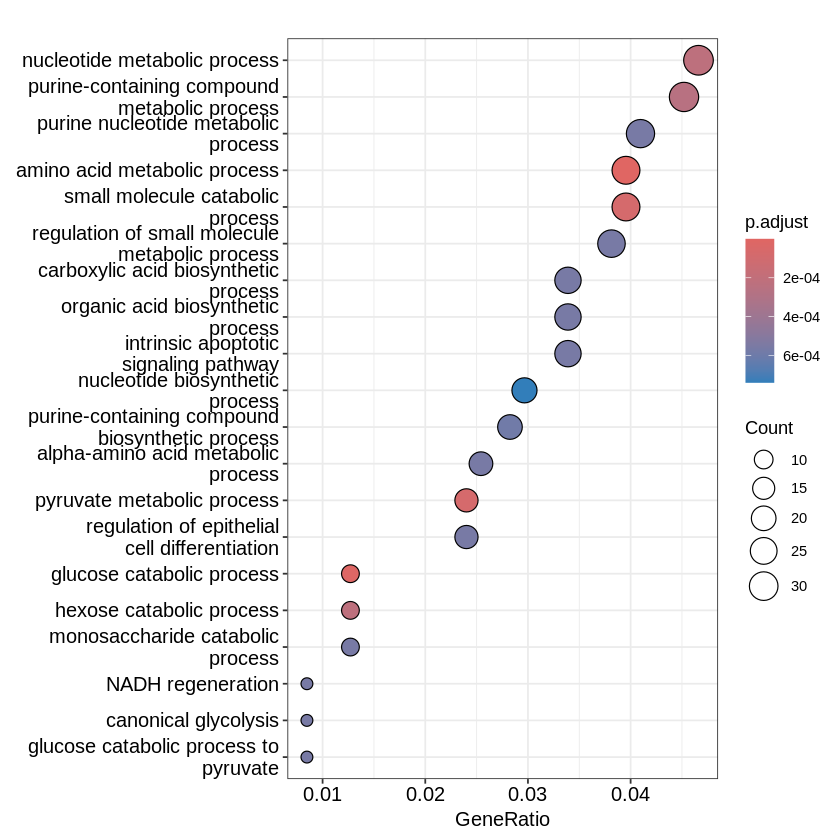

In [123]:
dotplot(goALL %>% filter(ONTOLOGY=="BP"), showCategory=20)#气泡图

In [124]:
pdf("../plots/012_GO_DOWN_CC.pdf",height = 12,width = 8)
dotplot(goALL %>% filter(ONTOLOGY=="CC"), showCategory=20)#气泡图
dev.off()

png 
  2

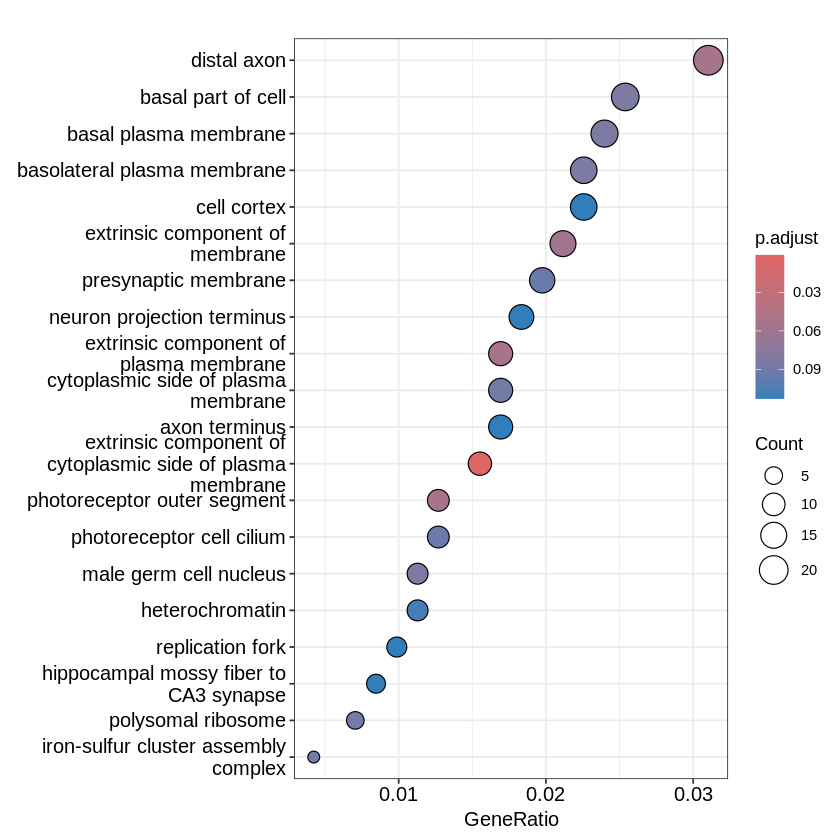

In [125]:
dotplot(goALL %>% filter(ONTOLOGY=="CC"), showCategory=20)#气泡图

In [126]:
pdf("../plots/012_GO_DOWN_MF.pdf",height = 12,width = 8)
dotplot(goALL %>% filter(ONTOLOGY=="MF"), showCategory=20)#气泡图
dev.off()

png 
  2

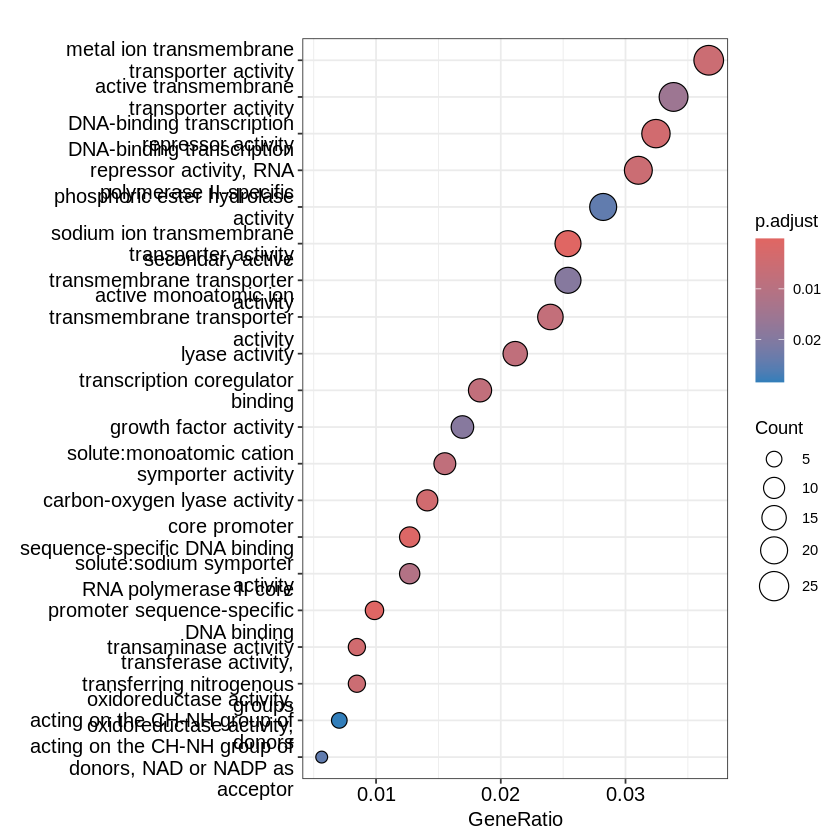

In [127]:
dotplot(goALL %>% filter(ONTOLOGY=="MF"), showCategory=20)#气泡图

In [128]:
pdf("../plots/012_GO_DOWN_merge.pdf",height = 12,width = 8)
dotplot(goALL, split="ONTOLOGY", showCategory=8) + facet_grid(ONTOLOGY~.,scale="free")
dev.off()

png 
  2

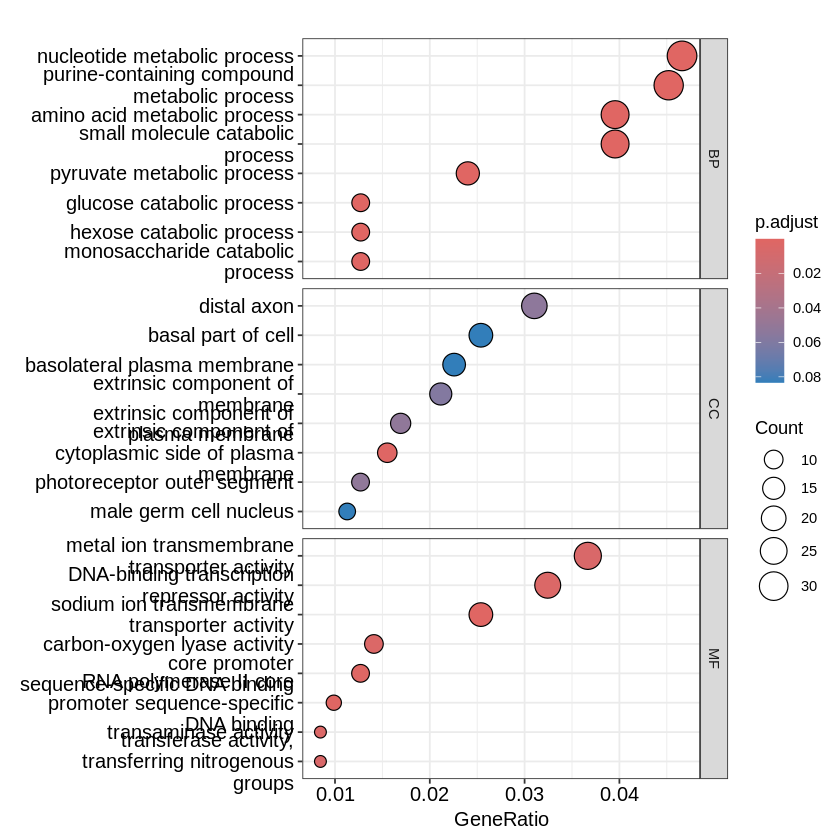

In [129]:
dotplot(goALL, split="ONTOLOGY", showCategory=8) + facet_grid(ONTOLOGY~.,scale="free")

如果遇到kegg的enrichKEGG return NULL的情况

https://github.com/YuLab-SMU/clusterProfiler/issues/561

```R
# 将 clusterprofilier 更新到最新的 Github 版本
remotes::install_github("YuLab-SMU/clusterProfiler") 

# 建立本地 KEGG 数据库
# install the packages
remotes::install_github("YuLab-SMU/createKEGGdb")
# import the library and create a KEGG database locally 
library(createKEGGdb)
species <-c("ath","hsa","mmu", "rno","dre","dme","cel")
createKEGGdb::create_kegg_db(species)
# You will get KEGG.db_1.0.tar.gz file in your working directory


# 安装并导入 KEGG.db
install.packages("KEGG.db_1.0.tar.gz", repos=NULL,type="source")
library(KEGG.db)


# enrichKEGG 函数中添加 use_internal_data=T

data(gcSample)
yy = enrichKEGG(gcSample[[5]], pvalueCutoff=0.01, use_internal_data=T)
head(summary(yy))
```

In [130]:
kegg_up <- enrichKEGG(genes_up_all_types$ENTREZID, organism = 'mmu', keyType = 'kegg', pvalueCutoff = 0.05, pAdjustMethod = 'BH', 
                        minGSSize = 3, maxGSSize = 500, qvalueCutoff = 0.2, use_internal_data = FALSE)
kegg_up

#
# over-representation test
#
#...@organism 	 mmu 
#...@ontology 	 KEGG 
#...@keytype 	 kegg 
#...@gene 	 chr [1:2174] "11650" "225468" "107585" "16855" "83564" "666806" "546024" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...63 enriched terms found
'data.frame':	63 obs. of  11 variables:
 $ category   : chr  NA "Organismal Systems" "Environmental Information Processing" "Environmental Information Processing" ...
 $ subcategory: chr  NA "Digestive system" "Signaling molecules and interaction" "Signal transduction" ...
 $ ID         : chr  "mmu04820" "mmu04974" "mmu04512" "mmu04151" ...
 $ Description: chr  "Cytoskeleton in muscle cells - Mus musculus (house mouse)" "Protein digestion and absorption - Mus musculus (house mouse)" "ECM-receptor interaction - Mus musculus (house mouse)" "PI3K-Akt signaling pathway - Mus musculus (house mouse)" ...
 $ GeneRatio  : chr  "63/877" "36/877" "27/877" "67/877" ...
 $ BgRatio    : chr  "229/9550" "108/9550" "89/9550" "364/9550" ...
 $ pv

In [131]:
kegg_down <- enrichKEGG(genes_down_all_types$ENTREZID, organism = 'mmu', keyType = 'kegg', pvalueCutoff = 0.05, pAdjustMethod = 'BH', 
                        minGSSize = 3, maxGSSize = 500, qvalueCutoff = 0.2, use_internal_data = FALSE)
kegg_down

#
# over-representation test
#
#...@organism 	 mmu 
#...@ontology 	 KEGG 
#...@keytype 	 kegg 
#...@gene 	 chr [1:764] "231214" "14171" "232210" "66059" "11474" "16818" "74776" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...11 enriched terms found
'data.frame':	11 obs. of  11 variables:
 $ category   : chr  "Metabolism" "Metabolism" "Human Diseases" "Human Diseases" ...
 $ subcategory: chr  "Global and overview maps" "Carbohydrate metabolism" "Cancer: overview" "Cancer: specific types" ...
 $ ID         : chr  "mmu01230" "mmu00010" "mmu05230" "mmu05216" ...
 $ Description: chr  "Biosynthesis of amino acids - Mus musculus (house mouse)" "Glycolysis / Gluconeogenesis - Mus musculus (house mouse)" "Central carbon metabolism in cancer - Mus musculus (house mouse)" "Thyroid cancer - Mus musculus (house mouse)" ...
 $ GeneRatio  : chr  "14/319" "10/319" "10/319" "7/319" ...
 $ BgRatio    : chr  "79/9550" "67/9550" "69/9550" "37/9550" ...
 $ pvalue     : num  2.83e-07 6.86e-05 8.87e-

In [132]:
pdf("../plots/013_KEGG_PATHWAY_up_dot.pdf",height = 12,width = 8)
dotplot(kegg_up, showCategory=20) #气泡图
dev.off()
pdf("../plots/013_KEGG_PATHWAY_up_bar.pdf",height = 12,width = 8)
barplot(kegg_up, showCategory=20,drop=T) #柱状图
dev.off()

png 
  2

png 
  2

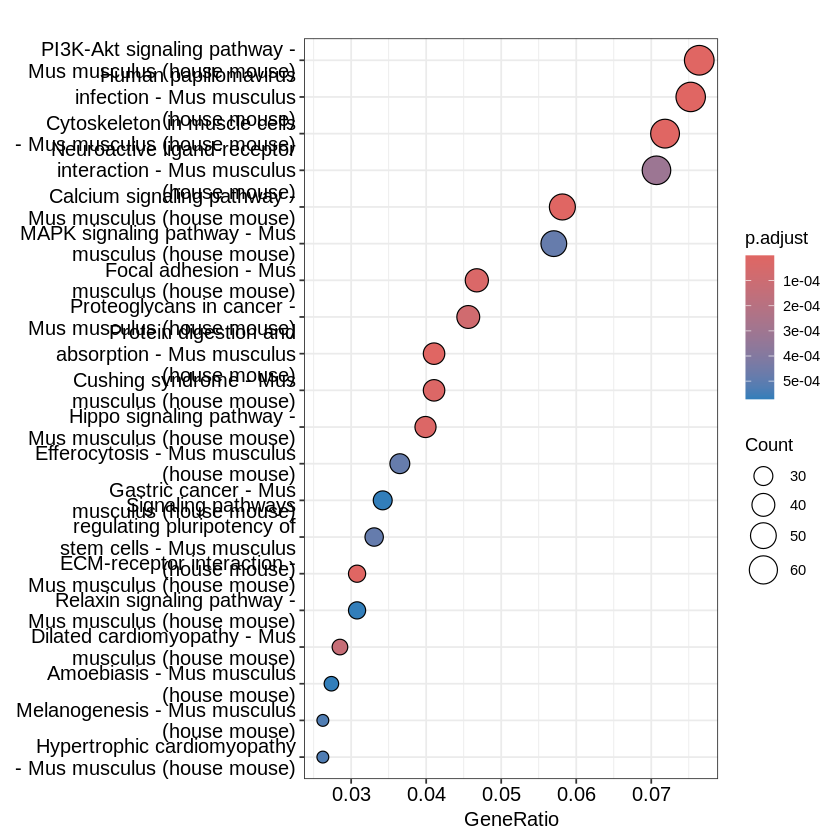

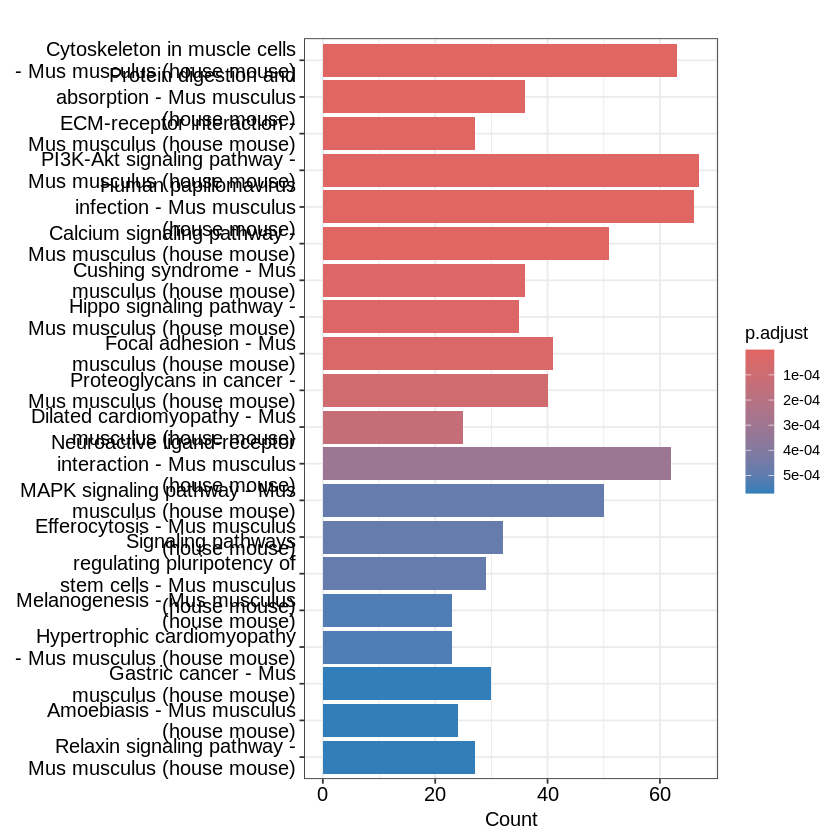

In [133]:
dotplot(kegg_up, showCategory=20) #气泡图
barplot(kegg_up, showCategory=20,drop=T) #柱状图

In [136]:
pdf("../plots/013_KEGG_PATHWAY_down_dot.pdf",height = 12,width = 8)
dotplot(kegg_down, showCategory=20) #气泡图
dev.off()
pdf("../plots/013_KEGG_PATHWAY_down_bar.pdf",height = 12,width = 8)
barplot(kegg_down, showCategory=20,drop=T) #柱状图
dev.off()

png 
  2

png 
  2

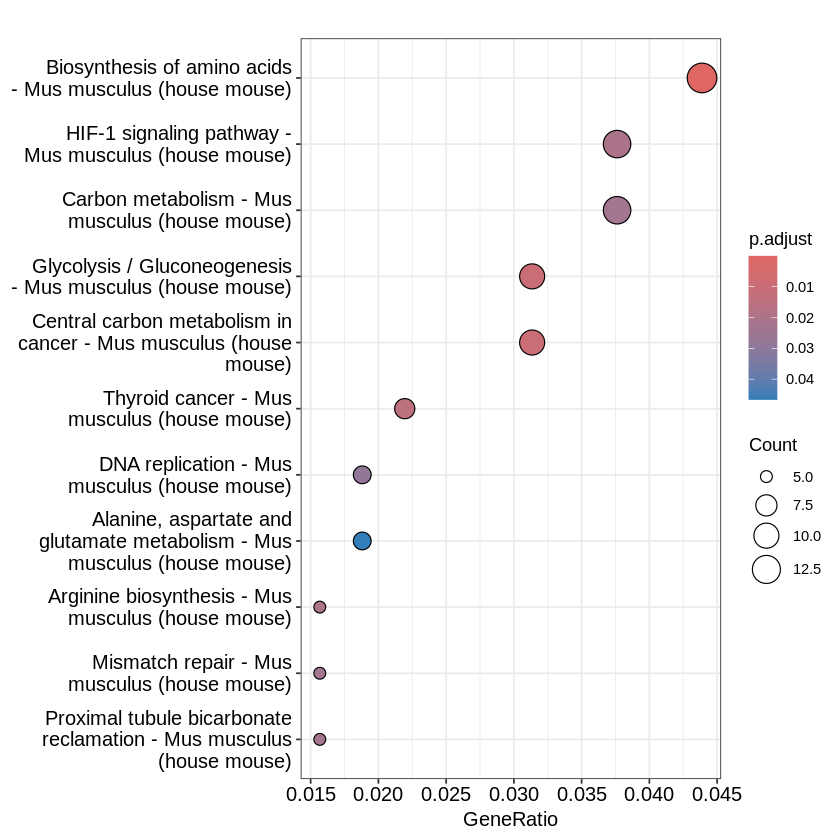

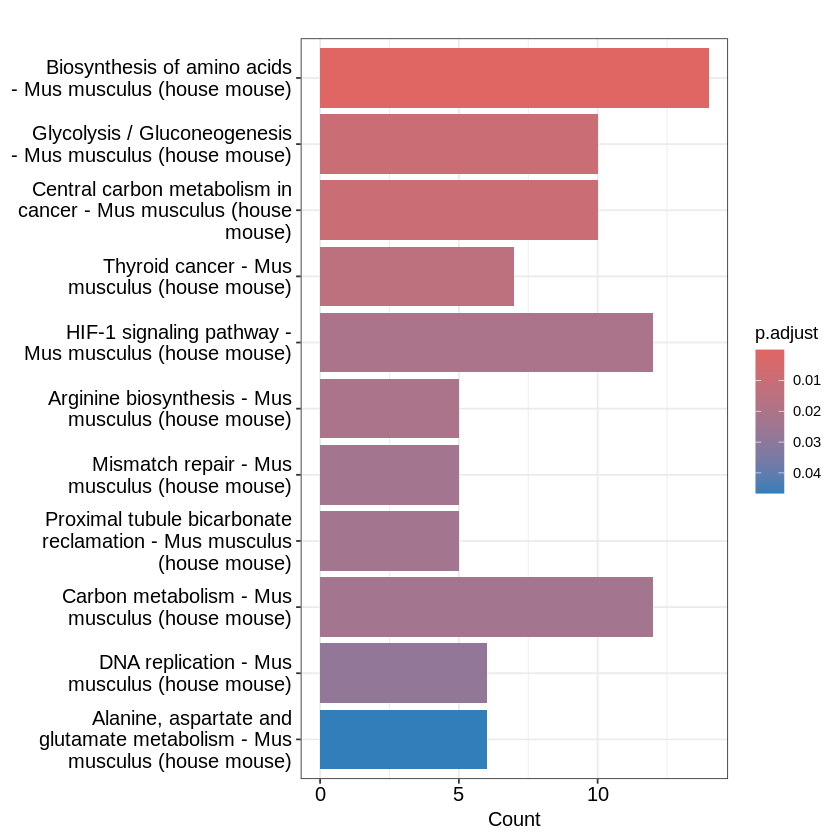

In [137]:
dotplot(kegg_down, showCategory=20) #气泡图
barplot(kegg_down, showCategory=20,drop=T) #柱状图

In [100]:
# #在pathway通路图上标记富集到的基因，会链接到KEGG官网
# browseKEGG(kegg, "hsa03728") 

# 【参考go】
https://mp.weixin.qq.com/s/W4K9it5ExtpNhpW9htMBJw